**Script overview**:
**Planespotters Aircraft Fleet Stock Preprocessing**

This script pre-processes the one-off snapshot of current aircraft (AC) in stock. This dataset was delivered by Planespotters for free. The excerpt is from 23 July 2019. 

The script corrects errors (typo-fixes, etc.), imputes missing data (e.g. year of build), and filters the passenger AC stock with status of 31 December 2018 (since we rely on a scheduled service data set from OAG from 2018).

Finally, some statistical analyses are performed on the preprocessed data and it is uploaded to the data server (pgAdmin).

# Pre-process data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
%matplotlib inline

In [2]:
def preview(dataframe, head=5):
    display(dataframe.head(head))
    print("This dataframe has " + str(len(dataframe)) + " observations.")

## Read in data

In [3]:
stock_raw = pd.read_excel('../delivery/2019-07-23_Planespotters.xlsx')

In [4]:
preview(stock_raw)

,Aircraft Manufacturer,Aircraft Type,Operator,Operator ID,Operator Category,Operator Country,Operator Parent/Group,Parent/Group ID,Parent/Group Country,First Operator,...,Build Country,First Customer Delivery Date,Delivery Date Operator,Exit Date Operator,Nr. of Engines,Engine Manufacturer,Engine Type,Config (Pax/Combi/Cargo/Other),Seat Total,Age (Years)
0,Aérospatiale/BAC,Aérospatiale/BAC Concorde,Aérospatiale,7312,Manufacturer,France,NaN,NaN,NaN,NaN,...,France,NaN,1967-12-01,NaN,4,Rolls-Royce/SNECMA,RR Olympus,NaN,0,50.4
1,Aérospatiale/BAC,Aérospatiale/BAC Concorde,Aérospatiale,7312,Manufacturer,France,NaN,NaN,NaN,NaN,...,France,NaN,1972-09-01,NaN,4,Rolls-Royce/SNECMA,RR Olympus,NaN,0,46.6
2,Aérospatiale/BAC,Aérospatiale/BAC Concorde,Aérospatiale,7312,Manufacturer,France,NaN,NaN,NaN,NaN,...,France,NaN,1973-12-01,NaN,4,Rolls-Royce/SNECMA,RR Olympus,NaN,0,45.7
3,Aérospatiale/BAC,Aérospatiale/BAC Concorde,Air France,1306,Airline,France,Air France-KLM,11321.0,France,Air France,...,France,1975-12-01,1980-06-01,NaN,4,Rolls-Royce/SNECMA,RR Olympus,Other,0,43.8
4,Aérospatiale/BAC,Aérospatiale/BAC Concorde,Air France,1306,Airline,France,Air France-KLM,11321.0,France,Air France,...,France,1976-01-01,1980-10-01,NaN,4,Rolls-Royce/SNECMA,RR Olympus,Other,0,25.5


This dataframe has 43286 observations.


In [5]:
pd.options.display.max_columns = None
display(stock_raw.iloc[1000:1003, :])

,Aircraft Manufacturer,Aircraft Type,Operator,Operator ID,Operator Category,Operator Country,Operator Parent/Group,Parent/Group ID,Parent/Group Country,First Operator,First Operator ID,First Operator Category,First Operator Country,Status,Build Date,Build Country,First Customer Delivery Date,Delivery Date Operator,Exit Date Operator,Nr. of Engines,Engine Manufacturer,Engine Type,Config (Pax/Combi/Cargo/Other),Seat Total,Age (Years)
1000,Airbus,Airbus A319-100,Aero Capital Solutions,10749,Leasing Company,United States,NaN,NaN,NaN,China Eastern Airlines,864.0,Airline,China,Stored,2001-07-01,Germany,2001-07-01,2018-08-01,NaN,2,CFM International,CFM56-5,NaN,0,18.1
1001,Airbus,Airbus A319-100,Aero Capital Solutions,10749,Leasing Company,United States,NaN,NaN,NaN,PrivatAir,8716.0,Business Airline,Germany,Stored,2003-04-01,Germany,2003-05-01,2018-12-01,NaN,2,International Aero Engines,V2500,NaN,0,16.3
1002,Airbus,Airbus A319-100,Aero Capital Solutions,10749,Leasing Company,United States,NaN,NaN,NaN,Czech Airlines (CSA),1042.0,Airline,Czech Republic,Stored,2007-02-01,Germany,2007-03-01,2019-03-01,NaN,2,CFM International,CFM56-5,NaN,0,12.4


In [6]:
stock_raw[stock_raw['Aircraft Type'] == 'Airbus A220-300'];

## Fix typos

The 'First Customer Delivery Date' contains some NaNs. These are preliminary filled with the date '1900-01-01' (which is earlier than any other AC in the data set with existing entries in that field). The preliminary replacement of NaNs is done to be able to process the data and do the following quality check.

For the following entries, the first customer delivery date has a month value greater than 12.

In [7]:
_check = stock_raw['First Customer Delivery Date'].fillna('1900-01-01')
_check[_check.str[5:7].astype(int) > 12].index

Int64Index([15585, 15662, 16056, 17388], dtype='int64')

The two month-digits have been mixed here. We fix that - hence, e.g. '1979-20-01' turns to '1979-02-01'.

In [8]:
stock_raw.at[15585,'First Customer Delivery Date'] = '1979-02-01'

In [9]:
stock_raw.at[15662,'First Customer Delivery Date'] = '1981-06-01'

In [10]:
stock_raw.at[16056,'First Customer Delivery Date'] = '1980-03-01'
stock_raw.at[16056,'Delivery Date Operator'] = '1980-03-01'

In [11]:
stock_raw.at[17388,'First Customer Delivery Date'] = '1987-02-01'

In [12]:
stock = stock_raw

## Assign unique aircraft names

In [13]:
# The CSeries has been renamed to Airbus A220-100/300.
stock.at[stock['Aircraft Type'] == 'Bombardier BD-500 CSeries CS100', 'Aircraft Type'] = 'Airbus A220-100'
stock.at[stock['Aircraft Type'] == 'Airbus A220-100', 'Aircraft Manufacturer'] = 'Airbus'

stock.at[stock['Aircraft Type'] == 'Bombardier BD-500 CSeries CS300', 'Aircraft Type'] = 'Airbus A220-300'
stock.at[stock['Aircraft Type'] == 'Airbus A220-300', 'Aircraft Manufacturer'] = 'Airbus'

In [14]:
# The 6 Airbus A300 B2 are mapped to the B4 since the B2 are not available in OAG and the B4 is the main production variant.
stock.at[stock['Aircraft Type'] == 'Airbus A300B2', 'Aircraft Type'] = 'Airbus A300B4'

## Select relevant Operator Category

Within the 'Operator Category' we observe not only airline AC, but also AC from other operators. Since this study focuses on scheduled services, we only keep the airline AC.

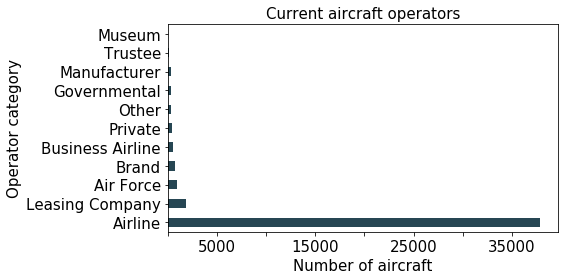

In [15]:
stock_Op_Cat = stock.groupby('Operator Category').size().sort_values(ascending = False) 
ax = stock_Op_Cat.plot.barh(figsize = (8,4), color='#264653')

plt.xlabel('Number of aircraft', fontsize = 15)
plt.ylabel('Operator category', fontsize = 15)
plt.title('Current aircraft operators', fontsize = 15)
plt.tick_params(labelsize=15)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
plt.tight_layout()
plt.savefig('..\gfx\AC_operators_raw.png', dpi=500)

In [16]:
_to_be_dropped = np.array(stock[stock['Operator Category'] != 'Airline'].index)
stock = stock.drop(_to_be_dropped, axis=0)

In [17]:
preview(stock)

,Aircraft Manufacturer,Aircraft Type,Operator,Operator ID,Operator Category,Operator Country,Operator Parent/Group,Parent/Group ID,Parent/Group Country,First Operator,First Operator ID,First Operator Category,First Operator Country,Status,Build Date,Build Country,First Customer Delivery Date,Delivery Date Operator,Exit Date Operator,Nr. of Engines,Engine Manufacturer,Engine Type,Config (Pax/Combi/Cargo/Other),Seat Total,Age (Years)
3,Aérospatiale/BAC,Aérospatiale/BAC Concorde,Air France,1306,Airline,France,Air France-KLM,11321.0,France,Air France,1306.0,Airline,France,Preserved,1975-10-01,France,1975-12-01,1980-06-01,NaN,4,Rolls-Royce/SNECMA,RR Olympus,Other,0,43.8
4,Aérospatiale/BAC,Aérospatiale/BAC Concorde,Air France,1306,Airline,France,Air France-KLM,11321.0,France,Air France,1306.0,Airline,France,Written Off,1975-01-01,France,1976-01-01,1980-10-01,NaN,4,Rolls-Royce/SNECMA,RR Olympus,Other,0,25.5
5,Aérospatiale/BAC,Aérospatiale/BAC Concorde,Air France,1306,Airline,France,Air France-KLM,11321.0,France,Air France,1306.0,Airline,France,Preserved,1976-03-01,France,1976-04-01,1980-06-01,NaN,4,Rolls-Royce/SNECMA,RR Olympus,Other,0,43.4
6,Aérospatiale/BAC,Aérospatiale/BAC Concorde,Air France,1306,Airline,France,Air France-KLM,11321.0,France,Air France,1306.0,Airline,France,Preserved,1976-07-01,France,1976-08-01,1980-06-01,NaN,4,Rolls-Royce/SNECMA,RR Olympus,Other,0,43.1
7,Aérospatiale/BAC,Aérospatiale/BAC Concorde,Air France,1306,Airline,France,Air France-KLM,11321.0,France,Air France,1306.0,Airline,France,Scrapped,1977-02-01,France,1977-03-01,1980-06-01,NaN,4,Rolls-Royce/SNECMA,RR Olympus,Other,0,16.8


This dataframe has 37817 observations.


## Filter only active and stored AC

The 'status' column tells us whether the AC is still active or stored, or whether it has already been scrapped, is on order, etc. Since we are only interested in the active and stored (as 'semi-active') AC fleet, we discard the rest.

In [18]:
stock_status = stock.groupby('Status').size().sort_values(ascending = False)
stock_status

Status
Active         27353
Stored          4543
Scrapped        4182
Written Off      831
On Order         596
Preserved        310
Unknown            1
Destroyed          1
dtype: int64

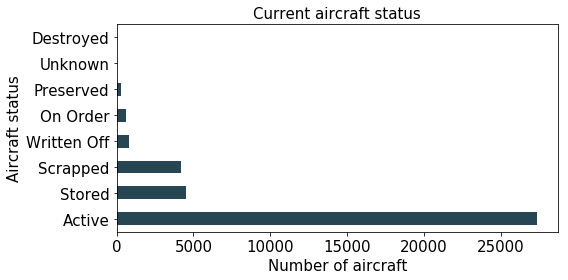

In [20]:
stock_status.plot.barh(figsize = (8,4), color='#264653')
plt.xlabel('Number of aircraft', fontsize = 15)
plt.ylabel('Aircraft status', fontsize = 15)
plt.title('Current aircraft status', fontsize = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()
plt.savefig('..\gfx\AC_status_raw.png', dpi=500)

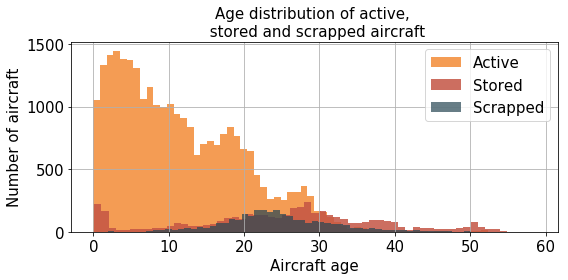

In [26]:
plt.figure(figsize = (8,4))
stock[stock['Status'] == 'Active']['Age (Years)'].hist(bins = 61, alpha = 0.95, label = 'Active', color='#f4974b')
stock[stock['Status'] == 'Stored']['Age (Years)'].hist(bins = 61, alpha = 0.85, label = 'Stored', color='#c45544')
stock[stock['Status'] == 'Scrapped']['Age (Years)'].hist(bins = 61, alpha = 0.7, label = 'Scrapped', color='#264653')
plt.legend(fontsize = 15)
plt.xlabel('Aircraft age', fontsize = 15)
plt.ylabel('Number of aircraft', fontsize = 15)
plt.title('Age distribution of active, \n stored and scrapped aircraft', fontsize = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()
plt.savefig('..\gfx\AC_age_raw.png', dpi=500)

From now on, we only look at the active and stored AC:

In [27]:
_to_be_dropped = np.array(stock[stock['Status'].isin(['Scrapped', 'Written Off', 'On Order', 'Preserved', 'Unknown', 'Destroyed'])].index)
stock = stock.drop(_to_be_dropped, axis=0)

In [28]:
preview(stock)

,Aircraft Manufacturer,Aircraft Type,Operator,Operator ID,Operator Category,Operator Country,Operator Parent/Group,Parent/Group ID,Parent/Group Country,First Operator,First Operator ID,First Operator Category,First Operator Country,Status,Build Date,Build Country,First Customer Delivery Date,Delivery Date Operator,Exit Date Operator,Nr. of Engines,Engine Manufacturer,Engine Type,Config (Pax/Combi/Cargo/Other),Seat Total,Age (Years)
20,Airbus,Airbus A220-100,Delta Air Lines,5673,Airline,United States,NaN,NaN,NaN,Delta Air Lines,5673.0,Airline,United States,Active,2018-10-01,Canada,2018-10-01,2018-10-01,NaN,2,Pratt & Whitney,PW1500G,Pax,109,0.8
21,Airbus,Airbus A220-100,Delta Air Lines,5673,Airline,United States,NaN,NaN,NaN,Delta Air Lines,5673.0,Airline,United States,Active,2018-11-01,Canada,2018-12-01,2018-12-01,NaN,2,Pratt & Whitney,PW1500G,Pax,109,0.7
22,Airbus,Airbus A220-100,Delta Air Lines,5673,Airline,United States,NaN,NaN,NaN,Delta Air Lines,5673.0,Airline,United States,Active,2018-12-01,Canada,2018-12-01,2018-12-01,NaN,2,Pratt & Whitney,PW1500G,Pax,109,0.6
23,Airbus,Airbus A220-100,Delta Air Lines,5673,Airline,United States,NaN,NaN,NaN,Delta Air Lines,5673.0,Airline,United States,Active,2018-12-01,Canada,2018-12-01,2018-12-01,NaN,2,Pratt & Whitney,PW1500G,Pax,109,0.6
24,Airbus,Airbus A220-100,Delta Air Lines,5673,Airline,United States,NaN,NaN,NaN,Delta Air Lines,5673.0,Airline,United States,Active,2019-02-01,Canada,2019-02-01,2019-02-01,NaN,2,Pratt & Whitney,PW1500G,Pax,109,0.5


This dataframe has 31896 observations.


## Impute NaNs in age / delivery date columns

**The goal of this section is to impute missing data in the 'Age (Years)' column. This is required for the stock & flow model.**

How many NaNs do we have in build date, first costumer delivery date and current operator delivery date?

In [29]:
print("The column 'Build Date' contains {} NaN values.".format(len(stock[stock['Build Date'].isnull()])))
print("The column 'First Customer Delivery Date' contains {} NaN values.".format(len(stock[stock['First Customer Delivery Date'].isnull()])))
print("The column 'Delivery Date Operator' contains {} NaN values.".format(len(stock[stock['Delivery Date Operator'].isnull()])))

The column 'Build Date' contains 55 NaN values.
The column 'First Customer Delivery Date' contains 14 NaN values.
The column 'Delivery Date Operator' contains 1 NaN values.


Get the number of entries where at least one of these three dates is NaN:

In [30]:
len(stock[ \
      stock['Build Date'].isnull() | \
      stock['First Customer Delivery Date'].isnull() | \
      stock['Delivery Date Operator'].isnull() \
     ])

69

*Note: "Age (Years)" refers to "Build Date", NOT "First Customer Delivery Date"* <br>
However, these two dates are usually not tooo far apart.<br>
Hence, for all entries where we have the first customer delivery date, but NOT the build date, we set the build date equal to the first customer delivery date and compute the age from that.

In [31]:
# Change datatype to datetime
stock['Build Date_dt_nan'] = pd.to_datetime(stock['Build Date'])
stock['First Customer Delivery Date_dt_nan'] = pd.to_datetime(stock['First Customer Delivery Date'])
stock['Delivery Date Operator_dt_nan'] = pd.to_datetime(stock['Delivery Date Operator'])

# Fill NaNs with value '1900-01-01'
stock['Build Date_dt_nan'] = stock['Build Date_dt_nan'].fillna(pd.to_datetime('1900-01-01'))
stock['First Customer Delivery Date_dt_nan'] = stock['First Customer Delivery Date_dt_nan'].fillna(pd.to_datetime('1900-01-01'))
stock['Delivery Date Operator_dt_nan'] = stock['Delivery Date Operator_dt_nan'].fillna(pd.to_datetime('1900-01-01'))

# Fill NaNs with value '119.63835616,
# which corresponds to the difference between '1900-01-01' and the excerpt date '2019-07-23'
stock['Age (Years)_nan'] = stock['Age (Years)'].fillna(119.63835616)

Now we set the build date equal to the first customer delivery date where we have the latter but not the former.

In [32]:
_idx = stock[stock['Build Date_dt_nan'] == pd.to_datetime('1900-01-01')].index
for i in _idx:
    stock.at[i,'Build Date_dt_nan'] = stock.loc[i,'First Customer Delivery Date_dt_nan']

Next, we compute the age by the difference of (1) the date of the data excerpt ('2019-07-23'), and (2) the imputed build date from the last step.

In [33]:
start_dt = stock.loc[:,'Build Date_dt_nan']
end_dt = pd.to_datetime('2019-07-23')

for i in _idx:
    _new_age = np.around(len(pd.date_range(start = start_dt[i], end = end_dt, freq='D'))/365, decimals = 2)
    stock.at[i,'Age (Years)_nan'] = _new_age

In [34]:
print("From previously {} missing age values,".format(len(stock[stock['Age (Years)'].isnull()])))
print("we came done to {} now".format(len(stock[stock['Age (Years)_nan'] == 119.64])))
print("(out of {} AC in the total data set).".format(len(stock)))

From previously 55 missing age values,
we came done to 1 now
(out of 31896 AC in the total data set).


So, finally we only have one AC where we don't have any information about the AC's age.  We discard that AC.

In [35]:
stock = stock.drop(np.array(stock[stock['Age (Years)_nan'] == 119.64].index), axis=0)

Now, we replace the old age and date columns by the new variables and update their names.

In [36]:
stock = stock.drop(['Build Date', 'First Customer Delivery Date', \
          'Delivery Date Operator','Age (Years)'], axis=1)

In [37]:
stock = stock.rename(columns={"First Customer Delivery Date_dt_nan": "First Customer Delivery Date",
                      "Delivery Date Operator_dt_nan": "Delivery Date Operator",
                      "Build Date_dt_nan": "Build Date",
                      "Age (Years)_nan": "Age (Years)"})

In [38]:
preview(stock)

,Aircraft Manufacturer,Aircraft Type,Operator,Operator ID,Operator Category,Operator Country,Operator Parent/Group,Parent/Group ID,Parent/Group Country,First Operator,First Operator ID,First Operator Category,First Operator Country,Status,Build Country,Exit Date Operator,Nr. of Engines,Engine Manufacturer,Engine Type,Config (Pax/Combi/Cargo/Other),Seat Total,Build Date,First Customer Delivery Date,Delivery Date Operator,Age (Years)
20,Airbus,Airbus A220-100,Delta Air Lines,5673,Airline,United States,NaN,NaN,NaN,Delta Air Lines,5673.0,Airline,United States,Active,Canada,NaN,2,Pratt & Whitney,PW1500G,Pax,109,2018-10-01,2018-10-01,2018-10-01,0.8
21,Airbus,Airbus A220-100,Delta Air Lines,5673,Airline,United States,NaN,NaN,NaN,Delta Air Lines,5673.0,Airline,United States,Active,Canada,NaN,2,Pratt & Whitney,PW1500G,Pax,109,2018-11-01,2018-12-01,2018-12-01,0.7
22,Airbus,Airbus A220-100,Delta Air Lines,5673,Airline,United States,NaN,NaN,NaN,Delta Air Lines,5673.0,Airline,United States,Active,Canada,NaN,2,Pratt & Whitney,PW1500G,Pax,109,2018-12-01,2018-12-01,2018-12-01,0.6
23,Airbus,Airbus A220-100,Delta Air Lines,5673,Airline,United States,NaN,NaN,NaN,Delta Air Lines,5673.0,Airline,United States,Active,Canada,NaN,2,Pratt & Whitney,PW1500G,Pax,109,2018-12-01,2018-12-01,2018-12-01,0.6
24,Airbus,Airbus A220-100,Delta Air Lines,5673,Airline,United States,NaN,NaN,NaN,Delta Air Lines,5673.0,Airline,United States,Active,Canada,NaN,2,Pratt & Whitney,PW1500G,Pax,109,2019-02-01,2019-02-01,2019-02-01,0.5


This dataframe has 31895 observations.


## Select and impute relevant AC configuration

**The scope of our study our passenger AC ('Pax'). This section filters the Pax AC from the cargo AC and imputes missing data.**

Let's have a look at the different entries for the AC configuration:

In [39]:
stock.groupby(['Config (Pax/Combi/Cargo/Other)']).size()

Config (Pax/Combi/Cargo/Other)
Cargo                 2447
Combi (Pax+Cargo)       35
Other                   17
Pax                  26615
dtype: int64

The 'groupby' function overview leaves out the NaNs. So, we have a look at them separately (called 'unlabeled AC' in the following).

In [40]:
labeled_stock = stock[~stock['Config (Pax/Combi/Cargo/Other)'].isnull()]

In [41]:
unlabeled_stock = stock[stock['Config (Pax/Combi/Cargo/Other)'].isnull()]

In [42]:
print("There are {} NaN values where we do not know whether it is Cargo, pax or anything else.".format(len(unlabeled_stock)))

There are 2781 NaN values where we do not know whether it is Cargo, pax or anything else.


In the following we address the categories 'Other', 'Combi (Pax+Cargo)', and 'NaN'.

### Category "Other"

At first, we look at the operator of all AC in the __"Other"__ category.

In [43]:
stock[stock['Config (Pax/Combi/Cargo/Other)'] == 'Other'].groupby(['Operator']).size().sort_values(ascending = False)

Operator
Airbus Transport International    5
Erickson Aero Tanker              4
Sideral Linhas Aéreas             2
2Excel Aviation                   2
PAL Aerospace                     1
Iraqi Airways                     1
Calm Air International            1
Aero-Dienst                       1
dtype: int64

Category __'Others' are mainly aircraft operated by aircraft manufacturers__:
- Airbus Transport International: transportation of AC parts during the manufacturing process of ACs). Furthermore, they are only 17 AC. 
- Erickson Aero Tanker: fire bombers
- Sideral Linhas Aéreas: cargo and charter flights
- 2Excel Aviation: unclear purpose (potentially in scope of our study about scheduled Pax flights)
- PAL Aerospace: regional airline (potentially in scope of our study about scheduled Pax flights)
- Iraqi Airways: national carrier of Iraq (potentially in scope of our study about scheduled Pax flights)
- Calm Air International: regional airline (potentially in scope of our study about scheduled Pax flights)
- Aero-Dienst: charter flights
<br>

Only 5 AC of the 17 in the configuration category 'Other' might potentially be in the scope of our study. However, since all of them offer not only scheduled Pax flights but also others, it is likely that they are used for non-scheduled services. Hence, we discard them.

In [44]:
_to_be_dropped = np.array(stock[stock['Config (Pax/Combi/Cargo/Other)'] == 'Other'].index)
stock = stock.drop(_to_be_dropped, axis=0)

### Category "Combi (Pax+Cargo)"

Now, we look at the Combi (Pax+Cargo) aircraft:

In [45]:
stock[stock['Config (Pax/Combi/Cargo/Other)'] == 'Combi (Pax+Cargo)'].groupby(['Operator']).size(). \
                sort_values(ascending = False)

Operator
Ryukyu Air Commuter            5
Nolinor Aviation               4
Jet2                           4
Air Transport International    4
First Air                      3
Canadian North                 3
Martinair Holland              2
EVA Airways                    2
Air Inuit                      2
Safair                         1
Perimeter Aviation             1
Nepal Airlines                 1
National Airlines              1
Chrono Aviation                1
Air India                      1
dtype: int64

We have a closer look at those airlines:
- Ryukyu Air Commuter: island-to-island services
- Nolinor Aviation: charter airline
- Jet2: offer scheduled services (potentially in scope of our study about scheduled Pax flights)
- Air Transport International: cargo an combi charter airline
- First Air: charter airline
- Canadian North: offer scheduled services (potentially in scope of our study about scheduled Pax flights)
- Martinair Holland: cargo airline
- EVA Airways: offer scheduled services (potentially in scope of our study about scheduled Pax flights)
- Air Inuit: offer scheduled services (potentially in scope of our study about scheduled Pax flights)
- Safair: cargo and charter airline
- Perimeter Aviation: offer scheduled services (potentially in scope of our study about scheduled Pax flights)
- Nepal Airlines: offer scheduled services (potentially in scope of our study about scheduled Pax flights)
- National Airlines: charter airline
- Chrono Aviation: charter airline
- Air India: offer scheduled services (potentially in scope of our study about scheduled Pax flights)

In a first step filter out all charter/cargo AC that our not included in the scope of our study:

In [46]:
_cargo_or_charter = stock[stock['Config (Pax/Combi/Cargo/Other)'] == 'Combi (Pax+Cargo)'] \
        [stock['Operator'].isin(list(['Ryukyu Air Commuter','Nolinor Aviation','Air Transport International', 'First Air', \
                                      'Martinair Holland', 'Safair', 'National Airlines', 'Chrono Aviation']))]

C:\Users\heldm\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [47]:
_to_be_dropped = np.array(_cargo_or_charter.index)
stock = stock.drop(_to_be_dropped, axis=0)

The AC of Jet2, Canadian North, Air Inuit, Nepal Airlines and Air India are all over 30 years old, wherefore it is likely that they have been converted to cargo AC. Therefore, we discard them.

In [48]:
_old_combi = stock[stock['Config (Pax/Combi/Cargo/Other)'] == 'Combi (Pax+Cargo)'] \
        [stock['Operator'].isin(list(['Jet2','Canadian North','Air Inuit', 'Nepal Airlines', 'Air India']))]

C:\Users\heldm\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [49]:
print(list(_old_combi.loc[:,'Age (Years)']))

[41.3, 39.9, 42.6, 39.3, 39.0, 32.9, 32.7, 31.3, 31.0, 30.8, 31.0]


In [50]:
_to_be_dropped = np.array(_old_combi.index)
stock = stock.drop(_to_be_dropped, axis=0)

The remaining three AC are operated by EVA Airways and Perimeter Aviation. Since they are around 25 years old, we keep them in our data set and classify them as Pax carriers.

In [51]:
_remaining_combi = stock[stock['Config (Pax/Combi/Cargo/Other)'] == 'Combi (Pax+Cargo)'] \
                    [stock['Operator'].isin(list(['EVA Airways', 'Perimeter Aviation']))]

C:\Users\heldm\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [52]:
print(list(_remaining_combi.loc[:,'Age (Years)']))

[23.4, 23.3, 25.6]


In [53]:
print(list(_remaining_combi.index))

[26378, 26379, 34816]


In [54]:
stock.at[26378,'Config (Pax/Combi/Cargo/Other)'] = 'Pax'
stock.at[26379,'Config (Pax/Combi/Cargo/Other)'] = 'Pax'
stock.at[34816,'Config (Pax/Combi/Cargo/Other)'] = 'Pax'

### Category "NaN"

In [55]:
print(stock['Config (Pax/Combi/Cargo/Other)'].unique())

['Pax' 'Cargo' nan]


Now, we have only left the following categories: <br>
- Cargo
- Pax
- NaNs

Next, we address the NaN values. (called "unlabeled AC" in the following)

In [56]:
labeled_stock = stock[~stock['Config (Pax/Combi/Cargo/Other)'].isnull()]

In [57]:
unlabeled_stock = stock[stock['Config (Pax/Combi/Cargo/Other)'].isnull()]

In [58]:
print("There are {} NaN values where we do not know whether it is Cargo, pax or anything else.".format(len(unlabeled_stock)))

There are 2781 NaN values where we do not know whether it is Cargo, pax or anything else.


**In the following, a set of different criteria is tested to find out what the AC configuration of the unlabelled AC is.**

<font color='blue'> ------------------------------------- <br>
__Test criterium No. of Seats:__ </font> How many seats do the unlabeled AC have?

In [59]:
unlabeled_stock.groupby(['Seat Total']).size()

Seat Total
0    2781
dtype: int64

<font color='blue'> __Conclusion:__ </font> All unlabeled AC have a seat number of 0. This would indicate that the unclassified AC are cargo AC, but "0" might also be the dummy value.

<font color='blue'>------------------------------------- <br>
__Test criterium AC status:__ </font> What is the status and age of the AC?

In [60]:
unlabeled_stock.groupby(['Status']).size().sort_values(ascending = False)

Status
Active    1604
Stored    1177
dtype: int64

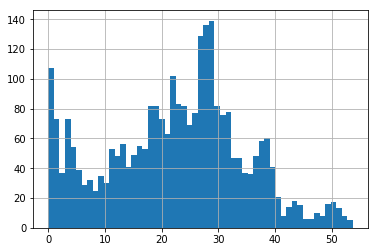

In [61]:
unlabeled_stock.loc[:,'Age (Years)'].hist(bins = 55)
plt.show()

<font color='blue'> __Conclusion:__ </font> Half of them are stored and not active, and they are mainly older. Maybe on hold for any type of operation (Pax or Cargo)? Still, no clear indication.

<font color='blue'>------------------------------------- <br>
__Test criterium "average age of unlabeled AC":__ </font> Is age a criterium to match the unlabled AC to the configuration category? (Assuming that Cargo AC are usually older than Pax?)

We look at the average age of all labeled AC.

In [62]:
labeled_stock.groupby(['Aircraft Type', 'Config (Pax/Combi/Cargo/Other)']).mean().loc[:,'Age (Years)']

Aircraft Type               Config (Pax/Combi/Cargo/Other)
ATR 42                      Cargo                             29.311905
                            Pax                               18.418705
ATR 72                      Cargo                             25.988525
                            Pax                                7.992102
Airbus A220-100             Pax                                0.996429
Airbus A220-300             Pax                                1.290196
Airbus A300-600             Cargo                             21.903933
                            Pax                               27.568421
Airbus A300B4               Cargo                             37.876471
                            Pax                               38.960000
Airbus A310-200             Cargo                             35.296552
                            Pax                               34.080000
Airbus A310-300             Cargo                             30.166667
     

We do the same grouping for the unlabeled AC.

In [63]:
unlabeled_stock.groupby(['Aircraft Type']).mean().loc[:,'Age (Years)']

Aircraft Type
ATR 42                        22.444262
ATR 72                        12.190994
Airbus A300-600               27.230435
Airbus A300B4                 37.990000
Airbus A310-200               34.125000
Airbus A310-300               28.966667
Airbus A319-100               14.979070
Airbus A320-200               13.946746
Airbus A320neo                 0.756897
Airbus A321-200                6.391837
Airbus A321neo                 0.583333
Airbus A330-200               12.857143
Airbus A330-300                9.580000
Airbus A340-200               26.000000
Airbus A340-300               20.856250
Airbus A340-500               13.420000
Airbus A380-800                1.200000
Antonov An-140                21.900000
Antonov An-148                 9.733333
Antonov An-158                14.300000
Antonov An-178                 4.200000
Beechcraft 1900               17.016667
Boeing 737 MAX 8               0.560000
Boeing 737 MAX 9               1.533333
Boeing 737-200            

<font color='blue'> __Conclusion:__ </font>
 By comparing the average age of labeled (Pax OR cargo) AC with average age of the unlabeled AC, we cannot draw a conclusion whether the unclassified AC are Pax or cargo AC.

<font color='blue'>------------------------------------- <br>
__Imputing missing data via a decision tree__ </font>

Since all the previous, statistical analyses have not turned out to be capable to tell the AC configuration of the unlabelled AC, we move on with a machine learning approach, in particular a decision tree. 

From the existing information on the AC configuration (from the labeled data set), we want to find a correlation based on multiple AC parameters that tells us when an AC has a high probability to be a Pax or Cargo AC. We choose the AC type, the operatur country, the status and the age as potential descriptive variables. From the found correlations, the decision tree predicts the label (= AC configuration) of the unlabeled data. Hence, inputs to the decision tree algorithm are the labeled and the unlabeled data.

At first, we need to preprocess the data set a little bit to make the data fit for the machine learning alogrithm:

In [64]:
def common_member(a, b): 
    '''takes two lists, returns elements that both lists have in common'''
    a_set = set(a) 
    b_set = set(b) 
      
    # check length  
    if len(a_set.intersection(b_set)) > 0: 
        return(a_set.intersection(b_set))   
    else: 
        return("no common elements") 

In [65]:
from sklearn import tree

target = labeled_stock.loc[:,'Config (Pax/Combi/Cargo/Other)']
train = labeled_stock.drop('Config (Pax/Combi/Cargo/Other)', axis =1)
pred = unlabeled_stock.drop('Config (Pax/Combi/Cargo/Other)', axis =1)

print("The prediction set initially contains {} entries.".format(len(pred)))

# Making sure that the train and predict data sets contain the same set of possible values.
# --> discarding all entries with unshared (among both data sets) AC type
cmn_AC_type = common_member(train['Aircraft Type'].unique(),pred['Aircraft Type'].unique())
train = train[train['Aircraft Type'].isin(cmn_AC_type)]
target = target.loc[train[train['Aircraft Type'].isin(cmn_AC_type)].index]
pred = pred[pred['Aircraft Type'].isin(cmn_AC_type)]

# --> discarding all entries with unshared (among both data sets) operator country
cmn_Op_cty = common_member(train['Operator Country'].unique(),pred['Operator Country'].unique())
train = train[train['Operator Country'].isin(cmn_Op_cty)]
target = target.loc[train[train['Operator Country'].isin(cmn_Op_cty)].index]
pred = pred[pred['Operator Country'].isin(cmn_Op_cty)]

# Since discarding unshared (among both data sets) operator countries might result into discarding one AC
# in one of both sets, we have to repeat step 1 and discard all uncommon AC types again
cmn_AC_type = common_member(train['Aircraft Type'].unique(),pred['Aircraft Type'].unique())
train = train[train['Aircraft Type'].isin(cmn_AC_type)]
target = target.loc[train[train['Aircraft Type'].isin(cmn_AC_type)].index]
pred = pred[pred['Aircraft Type'].isin(cmn_AC_type)]

print("The prediction set contains {} entries after discarding all entries where a feature entry \
(AC type or operator country) is   not in both sets (train and pred).".format(len(pred)))

The prediction set initially contains 2781 entries.
The prediction set contains 2738 entries after discarding all entries where a feature entry (AC type or operator country) is   not in both sets (train and pred).


Now, all possible combinations of AC type, and operator country are possible within the train and predict data set. (Note: This deletes only 43 entries in the prediction set via the cmn_xx_xx indices above. For these 43 AC, we cannot predict the label using the decision tree.)

In [66]:
# Setting up one-hot encoded dummy values for train and predict set
train_binary = pd.get_dummies(train[['Aircraft Type', \
                                    'Operator Country', 'Status', 'Age (Years)']],drop_first=True)
pred_binary = pd.get_dummies(pred[['Aircraft Type', \
                                    'Operator Country', 'Status', 'Age (Years)']],drop_first=True)

In [67]:
# Splitting into train and test sets to be able to calculate precision / recall
from sklearn.model_selection import train_test_split

x_trainset, x_testset, y_trainset, y_testset = train_test_split(train_binary, target, test_size=0.30, random_state=2)

In [68]:
# Training the decision tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_trainset, y_trainset)

In [69]:
# Computing precision and recall on test set
clf_pred = clf.predict(x_testset)
from sklearn.metrics import confusion_matrix,classification_report,precision_score
print(classification_report(y_testset,clf_pred))

             precision    recall  f1-score   support

      Cargo       0.83      0.85      0.84       663
        Pax       0.99      0.98      0.98      7082

avg / total       0.97      0.97      0.97      7745



In [70]:
# Cross-validating this finding on the whole training set
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator=clf, X=train_binary, y=target, cv=100)
scores

C:\Users\heldm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


array([0.74903475, 0.98069498, 0.98455598, 1.        , 0.996139  ,
       1.        , 1.        , 1.        , 0.99227799, 0.99227799,
       0.996139  , 0.94980695, 0.93050193, 0.99227799, 0.96911197,
       0.94208494, 0.98841699, 0.94208494, 0.95366795, 0.94208494,
       0.97683398, 0.98455598, 0.98455598, 0.98069498, 0.98841699,
       0.99227799, 0.98069498, 0.98069498, 0.996139  , 0.996139  ,
       0.97297297, 0.83783784, 0.89189189, 0.97683398, 0.98841699,
       0.94980695, 0.98455598, 0.91505792, 0.94573643, 0.96899225,
       0.99224806, 0.9379845 , 0.59689922, 0.62790698, 0.96124031,
       0.9379845 , 0.93023256, 0.9379845 , 0.97674419, 0.93410853,
       0.96899225, 0.9379845 , 0.94573643, 0.96899225, 1.        ,
       1.        , 0.85658915, 0.94186047, 0.95736434, 0.98837209,
       0.99612403, 0.95348837, 0.9379845 , 0.96124031, 0.93023256,
       0.98062016, 0.98837209, 1.        , 0.98837209, 0.70542636,
       0.54263566, 0.35271318, 0.65116279, 0.5620155 , 0.86046

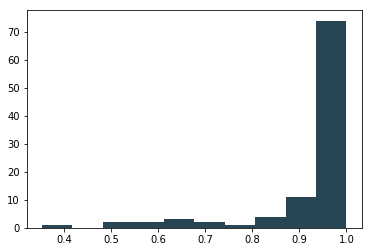

In [71]:
plt.hist(scores, color='#264653')
plt.show()

In [70]:
# Predict values for prediction set
predicted_pax_cargo = pd.DataFrame(clf.predict(pred_binary))

In [71]:
print("Result: {} AC have been classified as cargo AC, {} as pax AC.".format(predicted_pax_cargo.groupby(0).size()[0], predicted_pax_cargo.groupby(0).size()[1]))

Result: 275 AC have been classified as cargo AC, 2463 as pax AC.


The decision tree has chosen the following features for classifying the data:

In [72]:
dict_ft_importance = dict(zip(train_binary.columns, clf.feature_importances_))

The 20 most important classifying features are:

In [73]:
for key, value in sorted(dict_ft_importance.items(), key=lambda item: item[1], reverse=True)[:20]:
    print("%s: %s" % (key, value))

Age (Years): 0.3806551900550292
Aircraft Type_Airbus A300-600: 0.04733608670330048
Status_Stored: 0.04610891964671886
Operator Country_United States: 0.041684184270559366
Aircraft Type_Boeing 767-300: 0.04083915968820981
Aircraft Type_Boeing 747-400: 0.035102902022565434
Operator Country_China: 0.031742048421442806
Aircraft Type_Boeing 777-200: 0.027701284926976523
Aircraft Type_Boeing 737-400: 0.026729314122102242
Aircraft Type_Boeing 757-200: 0.025618336674237064
Aircraft Type_McDonnell Douglas MD-11: 0.0204037388278336
Aircraft Type_Airbus A320-200: 0.01843459983878123
Aircraft Type_McDonnell Douglas MD-88: 0.017518583258519217
Aircraft Type_Douglas DC-8-60/70: 0.017009388652191225
Aircraft Type_Boeing 747-200: 0.016576119815893173
Aircraft Type_British Aerospace BAe ATP: 0.01384699413970765
Aircraft Type_Airbus A310-200: 0.009240624637662283
Aircraft Type_Boeing 737-300: 0.008512121425081502
Operator Country_Germany: 0.007816632707107045
Aircraft Type_ATR 72: 0.007608636030387467


Finally, we plot the decision tree:

In [75]:
from sklearn.externals.six import StringIO  
import io
import os
import sys
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import pydot

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Image(graph.create_png())

# fix function for graphviz on Windows (Source: Stackoverflow)
def conda_fix(graph):
    path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")   # <--- EXECUTABLES MUST BE IN THIS DIRECTORY
    paths = ("dot", "twopi", "neato", "circo", "fdp")
    paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
    graph.set_graphviz_executables(paths)

names_mod = list(train_binary)

with io.StringIO() as buff:
    tree.export_graphviz(clf, out_file=buff, max_depth=8, feature_names = names_mod)
    graph = pydotplus.graph_from_dot_data(buff.getvalue())
    
# When using Windows: apply line below    //  When using Mac: comment it
conda_fix(graph)

#Image(graph.create_png())
graph.write_pdf('..\gfx\decision_tree.pdf')

True

<font color='blue'>------------------------------------- <br>
__Statistical test of decision tree reliability:__ </font> Are there Pax only or Cargo only AC types in the labeled data, so that we can impute the label for these AC of the unlabeled data set?
Assuming Pax/Cargo only AC types are *always* in that configuration, we can check whether the decision tree has chosen the right labels for these AC types.

What is the Pax-Cargo-distribution per AC type for all labeled AC?

In [76]:
pd.set_option('display.max_rows', 500)
stock[~stock['Config (Pax/Combi/Cargo/Other)'].isnull()].groupby(['Aircraft Type', 'Config (Pax/Combi/Cargo/Other)']).size()

Aircraft Type                   Config (Pax/Combi/Cargo/Other)
ATR 42                          Cargo                               42
                                Pax                                139
ATR 72                          Cargo                               61
                                Pax                                628
Airbus A220-100                 Pax                                 28
Airbus A220-300                 Pax                                 51
Airbus A300-600                 Cargo                              178
                                Pax                                 19
Airbus A300B4                   Cargo                               34
                                Pax                                  5
Airbus A310-200                 Cargo                               29
                                Pax                                  5
Airbus A310-300                 Cargo                               24
              

Apparently there are quite some AC that are only operated as Pax. <br>

Assuming that this holds generally, the labels for these AC should have been set to 'Pax' by the decision tree. We check this in the following:

In [77]:
# AC types that are operated as 'Cargo only' or as 'Cargo' and 'Pax' (= opposite set of 'Pax only')
cargo_AC_type_list = stock[stock['Config (Pax/Combi/Cargo/Other)'] == 'Cargo'].loc[:, 'Aircraft Type'].unique()

In [78]:
# AC within the list of unlabeled AC that are operated as Pax only
pax_only = ~stock.loc[stock['Config (Pax/Combi/Cargo/Other)'].isnull(),'Aircraft Type'].isin(cargo_AC_type_list)
pax_only_index = [pax_only.index[i] for i, x in enumerate(pax_only) if x]

In [79]:
print("Based on the assumption above, {} out of {} unlabeled AC have been classified correctly. This is a rate of {:.2f} %."\
      .format(
      len(common_member(pax_only_index, pred[(np.array(predicted_pax_cargo) == 'Pax')].index)),
      len(pax_only_index),
      len(common_member(pax_only_index, pred[(np.array(predicted_pax_cargo) == 'Pax')].index))/ \
      len(pax_only_index) * 100
      ))

Based on the assumption above, 916 out of 946 unlabeled AC have been classified correctly. This is a rate of 96.83 %.


This gives a good indication that the other labels are imputed in similar accuracy. However, the classification remains uncertain because the decision tree classifies the rest of the labels via other features (mainly age and AC status). 

<font color='blue'> __Conclusion:__ </font>
We set the labels of the unlabeled AC to the predicted labels, since this is the best of our knowledge on the AC configuration on the unlabeled data set.

In [80]:
for i in np.arange(len(pred.index)):
    stock.at[pred.index[i], 'Config (Pax/Combi/Cargo/Other)'] = predicted_pax_cargo.loc[i,0]


In [83]:
print("Now, there are {} NaN values left where we do not know whether it is Cargo, pax or anything else.".format(len(stock[stock['Config (Pax/Combi/Cargo/Other)'].isnull()])))
print("These {} NaN values are the ones that have been sorted out by the decision tree at its initialization.".format(len(stock[stock['Config (Pax/Combi/Cargo/Other)'].isnull()])))

Now, there are 43 NaN values left where we do not know whether it is Cargo, pax or anything else.
These 43 NaN values are the ones that have been sorted out by the decision tree at its initialization.


In [84]:
stock[stock['Config (Pax/Combi/Cargo/Other)'].isnull()].groupby('Status').mean()['Age (Years)']

Status
Active    19.912857
Stored    35.022727
Name: Age (Years), dtype: float64

From these 43 AC, the un-active, stored AC are quite old. We discard them in the following.

In [85]:
_stored = stock[(stock['Config (Pax/Combi/Cargo/Other)'].isnull()) & (stock['Status'] == 'Stored')]

In [86]:
_to_be_dropped = np.array(_stored.index)
stock = stock.drop(_to_be_dropped, axis=0)

Finally, we have a look at the remaining AC:

In [87]:
stock[stock['Config (Pax/Combi/Cargo/Other)'].isnull()]['Aircraft Type']

1888                          Airbus A319-100
1889                          Airbus A319-100
12664                          Antonov An-178
12729                                  ATR 42
15758                          Boeing 737-200
16656                          Boeing 737-300
16674                          Boeing 737-300
16790                          Boeing 737-300
17798                          Boeing 737-400
33849               British Aerospace 146-300
34250    De Havilland Canada DHC-6 Twin Otter
36301                         Embraer E190-E2
36302                         Embraer E190-E2
36303                         Embraer E190-E2
36958                         Embraer ERJ-145
39627                              Fokker F50
39628                              Fokker F50
42821                                Saab 340
42928                                Saab 340
43282                         Yakovlev Yak-42
43283                         Yakovlev Yak-42
Name: Aircraft Type, dtype: object

Only the 'Antonov An-178' is a dedicated freighter. Hence, we set this to a Cargo configuration, and the others to a Pax configuration.

In [88]:
stock.at[12664,'Config (Pax/Combi/Cargo/Other)'] = 'Cargo'

In [89]:
_idx = np.array(stock[stock['Config (Pax/Combi/Cargo/Other)'].isnull()]['Aircraft Type'].index)
for i in _idx:
    stock.at[i,'Config (Pax/Combi/Cargo/Other)'] = 'Pax'

Our final data set look like this:

In [90]:
stock.groupby(['Status', 'Config (Pax/Combi/Cargo/Other)']).count()['Aircraft Type']

Status  Config (Pax/Combi/Cargo/Other)
Active  Cargo                              2167
        Pax                               25145
Stored  Cargo                               556
        Pax                                3956
Name: Aircraft Type, dtype: int64

Since we will need the total stock (Pax + Cargo) later on for validation, we save the dataframe in another variable:

In [91]:
stock_Pax_Cargo = stock

However, from now on we are only looking at Pax AC. Therefore, we discard the cargo AC here.

In [92]:
_to_be_dropped = np.array(stock[stock['Config (Pax/Combi/Cargo/Other)'] == 'Cargo'].index)
stock = stock.drop(_to_be_dropped, axis=0)

In [93]:
preview(stock)

,Aircraft Manufacturer,Aircraft Type,Operator,Operator ID,Operator Category,Operator Country,Operator Parent/Group,Parent/Group ID,Parent/Group Country,First Operator,First Operator ID,First Operator Category,First Operator Country,Status,Build Country,Exit Date Operator,Nr. of Engines,Engine Manufacturer,Engine Type,Config (Pax/Combi/Cargo/Other),Seat Total,Build Date,First Customer Delivery Date,Delivery Date Operator,Age (Years)
20,Airbus,Airbus A220-100,Delta Air Lines,5673,Airline,United States,NaN,NaN,NaN,Delta Air Lines,5673.0,Airline,United States,Active,Canada,NaN,2,Pratt & Whitney,PW1500G,Pax,109,2018-10-01,2018-10-01,2018-10-01,0.8
21,Airbus,Airbus A220-100,Delta Air Lines,5673,Airline,United States,NaN,NaN,NaN,Delta Air Lines,5673.0,Airline,United States,Active,Canada,NaN,2,Pratt & Whitney,PW1500G,Pax,109,2018-11-01,2018-12-01,2018-12-01,0.7
22,Airbus,Airbus A220-100,Delta Air Lines,5673,Airline,United States,NaN,NaN,NaN,Delta Air Lines,5673.0,Airline,United States,Active,Canada,NaN,2,Pratt & Whitney,PW1500G,Pax,109,2018-12-01,2018-12-01,2018-12-01,0.6
23,Airbus,Airbus A220-100,Delta Air Lines,5673,Airline,United States,NaN,NaN,NaN,Delta Air Lines,5673.0,Airline,United States,Active,Canada,NaN,2,Pratt & Whitney,PW1500G,Pax,109,2018-12-01,2018-12-01,2018-12-01,0.6
24,Airbus,Airbus A220-100,Delta Air Lines,5673,Airline,United States,NaN,NaN,NaN,Delta Air Lines,5673.0,Airline,United States,Active,Canada,NaN,2,Pratt & Whitney,PW1500G,Pax,109,2019-02-01,2019-02-01,2019-02-01,0.5


This dataframe has 29101 observations.


## Merge aircraft that are not in OAG

In [94]:
# For the following aircraft types either another variant was considered since there was only this single one in OAG, or
# it was renamed to standard PS names (e.g. Avro RJ85 and British Aerospace Avro RJ85 exist -> both are given the same name).
_rename_ps_name = {'Airbus A310-200': 'Airbus A310-300',
'Airbus A321-100': 'Airbus A321-200',
'Boeing 747-100': 'Boeing 747-400',
'Boeing 747-200': 'Boeing 747-400',
'Boeing 747-300': 'Boeing 747-400',
'Boeing 747SP': 'Boeing 747-400',
'McDonnell Douglas DC-10-10': 'McDonnell Douglas DC-9',
'McDonnell Douglas DC-10-30': 'McDonnell Douglas DC-9',
'McDonnell Douglas DC-9-10': 'McDonnell Douglas DC-9',
'McDonnell Douglas DC-9-20': 'McDonnell Douglas DC-9',
'McDonnell Douglas DC-9-30': 'McDonnell Douglas DC-9',
'McDonnell Douglas DC-9-50': 'McDonnell Douglas DC-9',
'McDonnell Douglas MD-11': 'McDonnell Douglas DC-9',
'British Aerospace Avro RJ70': 'British Aerospace Avro RJ85',
'Avro RJ85': 'British Aerospace Avro RJ85',
'Embraer E190-E2': 'Embraer ERJ-190',
'McDonnell Douglas DC-9-40': 'McDonnell Douglas DC-9',
'Tupolev Tu-214': 'Tupolev Tu-204',
'Embraer ERJ-140': 'Embraer ERJ-135'}

In [95]:
stock['Aircraft Type'] = stock['Aircraft Type'].replace(_rename_ps_name)

## Distribute Planespotters ac types to multiple OAG ac types

For some unique ac types in Planespotters, multiple entries in OAG exist. They are:

- PS: "Boeing 777-200" | OAG: "Boeing 777-200/200ER Passenger & Boeing 777-200LR" | "IATA: 772 & 77L" | "ICAO: B772 & B77L"
- PS: "Boeing 777-300" | OAG: "Boeing 777-300 Passenger & Boeing 777-300ER Passenger" | "IATA: 773 & 77W" | "ICAO: B773 & B77W"
- PS: "Embraer ERJ-175" | OAG: "Embraer 175 & Embraer 175 (Enhanced Winglets)" | "IATA: E75 & E7W" | "ICAO: E75S & E75L"

Since we want to have a unique ICAO-IATA-OAG-PS matching, we separate the number of PS ac to the two different IATA/ICAO ac variants according to the fkm shares for the two variants from OAG. This fkm-share-based separation assumes the same utilization rate for all variants which should be refined if accurate knowledge is given for utilization rates in the future.

**Load OAG data**

In [96]:
# Connect to DB
%load_ext ipython_pg.LAV
%pg_connect dbname='mobility' host='lav-fileserver.ethz.ch' user='heldm'

password for heldm@lav-fileserver.ethz.ch:5433:········
SUCCESS: connected to lav-fileserver.ethz.ch
  PostGIS integration enabled

In [97]:
%%pg_pd oag18
SELECT * FROM "OAG"."2018_schedule"

SUCCES: matched 180578 rows
 results stored as 'oag18'


**Boeing 777-200**

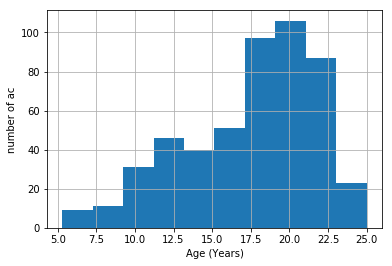

In [99]:
stock[stock['Aircraft Type'] == 'Boeing 777-200']['Age (Years)'].hist()
plt.xlabel('Age (Years)')
plt.ylabel('number of ac')
plt.show()

The entry-into-service of the 777-200 was in 1995. The eis of the 777-200LR was in 2006. You can even see that in the Age (Years) histogram above. Even if production of the base 777-200 is likely to have continued after 2006, our first order approximation is the assignment of new ac to the LR version.

In [100]:
# Define fkm shares for both variants
fkm_772 = oag18[oag18['ac_code_iata'] == '772']['fkm_2018'].sum()
fkm_77L = oag18[oag18['ac_code_iata'] == '77L']['fkm_2018'].sum()
share_772 = fkm_772 / (fkm_772 + fkm_77L)
share_77L = fkm_77L / (fkm_772 + fkm_77L)

In [101]:
# Number of ac in PS
num_ac_ps = len(stock[stock['Aircraft Type'] == 'Boeing 777-200'])
num_ac_772 = int(np.round((share_772 * num_ac_ps)))
num_ac_77L = int(np.round((share_77L * num_ac_ps)))
num_ac_ps - num_ac_772 - num_ac_77L # sanity-check

0

In [102]:
idx_772 = stock[stock['Aircraft Type'] == 'Boeing 777-200'].nlargest(num_ac_772,'Age (Years)').index
stock.at[idx_772, 'Aircraft Type'] = 'Boeing 777-200 NormalRange'

In [103]:
idx_77L = stock[stock['Aircraft Type'] == 'Boeing 777-200'].index
stock.at[idx_77L, 'Aircraft Type'] = 'Boeing 777-200 LongRange'

In [104]:
# Sanity Check
print(len(stock[stock['Aircraft Type'] == 'Boeing 777-200 NormalRange']) - num_ac_772)
print(len(stock[stock['Aircraft Type'] == 'Boeing 777-200 LongRange']) - num_ac_77L)

0
0


**Boeing 777-300**

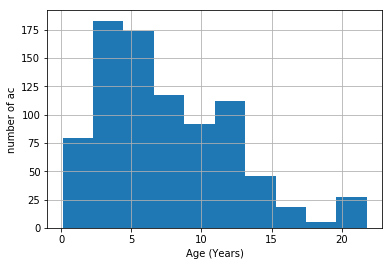

In [105]:
stock[stock['Aircraft Type'] == 'Boeing 777-300']['Age (Years)'].hist()
plt.xlabel('Age (Years)')
plt.ylabel('number of ac')
plt.show()

The entry-into-service of the 777-300 was in 1997 and it was produced until 2006. The eis of the 777-300ER was in 2004. Our first order approximation is the assignment of new ac to the ER version.

In [106]:
# Define fkm shares for both variants
fkm_777 = oag18[oag18['ac_code_iata'] == '777']['fkm_2018'].sum()
fkm_77W = oag18[oag18['ac_code_iata'] == '77W']['fkm_2018'].sum()
share_777 = fkm_777 / (fkm_777 + fkm_77W)
share_77W = fkm_77W / (fkm_777 + fkm_77W)

In [107]:
# Number of ac in PS
num_ac_ps = len(stock[stock['Aircraft Type'] == 'Boeing 777-300'])
num_ac_777 = int(np.round((share_777 * num_ac_ps)))
num_ac_77W = int(np.round((share_77W * num_ac_ps)))
num_ac_ps - num_ac_777 - num_ac_77W # sanity-check

0

In [108]:
idx_777 = stock[stock['Aircraft Type'] == 'Boeing 777-300'].nlargest(num_ac_777,'Age (Years)').index
stock.at[idx_777, 'Aircraft Type'] = 'Boeing 777-300 NormalRange'

In [109]:
idx_77W = stock[stock['Aircraft Type'] == 'Boeing 777-300'].index
stock.at[idx_77W, 'Aircraft Type'] = 'Boeing 777-300 ExtendedRange'

In [110]:
# Sanity Check
print(len(stock[stock['Aircraft Type'] == 'Boeing 777-300 NormalRange']) - num_ac_777)
print(len(stock[stock['Aircraft Type'] == 'Boeing 777-300 ExtendedRange']) - num_ac_77W)

0
0


**Embraer ERJ-175**

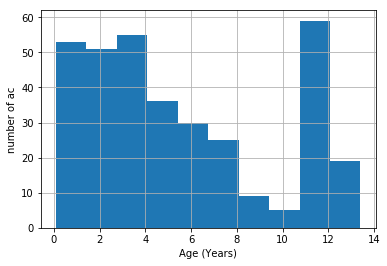

In [111]:
stock[stock['Aircraft Type'] == 'Embraer ERJ-175']['Age (Years)'].hist()
plt.xlabel('Age (Years)')
plt.ylabel('number of ac')
plt.show()

There is no information available on different entries-into-service for both ac variants. However, one can assume that the enhanced winglet variant has been introduced more recently. Our first order approximation is the assignment of new ac to the ER version.

In [112]:
# Define fkm shares for both variants
fkm_E75 = oag18[oag18['ac_code_iata'] == 'E75']['fkm_2018'].sum()
fkm_E7W = oag18[oag18['ac_code_iata'] == 'E7W']['fkm_2018'].sum()
share_E75 = fkm_E75 / (fkm_E75 + fkm_E7W)
share_E7W = fkm_E7W / (fkm_E75 + fkm_E7W)

In [113]:
# Number of ac in PS
num_ac_ps = len(stock[stock['Aircraft Type'] == 'Embraer ERJ-175'])
num_ac_E75 = int(np.round((share_E75 * num_ac_ps)))
num_ac_E7W = int(np.round((share_E7W * num_ac_ps)))
num_ac_ps - num_ac_E75 - num_ac_E7W # sanity-check

0

In [114]:
idx_E75 = stock[stock['Aircraft Type'] == 'Embraer ERJ-175'].nlargest(num_ac_E75,'Age (Years)').index
stock.at[idx_E75, 'Aircraft Type'] = 'Embraer ERJ-175 Base'

In [115]:
idx_E7W = stock[stock['Aircraft Type'] == 'Embraer ERJ-175'].index
stock.at[idx_E7W, 'Aircraft Type'] = 'Embraer ERJ-175 EnhancedWinglets'

In [116]:
# Sanity Check
print(len(stock[stock['Aircraft Type'] == 'Embraer ERJ-175 Base']) - num_ac_E75)
print(len(stock[stock['Aircraft Type'] == 'Embraer ERJ-175 EnhancedWinglets']) - num_ac_E7W)

0
0


## Seat number imputation

Now, we assign the average seat value of the corresponding AC type to all previously unlabeled AC.

In [118]:
seat_info_yes = stock[stock['Seat Total'] != 0]

In [119]:
seat_info_no = stock[stock['Seat Total'] == 0]

In [120]:
len(seat_info_no)

2551

In [121]:
no_seat_number_found = []
for i in seat_info_no.index:
    _AC_type = seat_info_no.loc[i,'Aircraft Type']
    if np.isin(_AC_type, seat_info_yes['Aircraft Type'].unique()):
        seat_info_no.at[i, 'Seat Total'] = round(seat_info_yes[seat_info_yes.loc[:,'Aircraft Type'] == _AC_type].loc[:,'Seat Total'].mean())
    else:
        no_seat_number_found = np.append(no_seat_number_found, [_AC_type], axis = 0)

Finally, we set the seat numbers saved in the seat_info_no dataframe also to the stock dataframe:

In [122]:
for i in seat_info_no.index:
    stock.at[i, 'Seat Total'] = seat_info_no.loc[i, 'Seat Total']

In [123]:
print("Our final stock contains {} aircraft. The following analyses will be based on this subset of the raw data.".format(len(stock)))

Our final stock contains 29101 aircraft. The following analyses will be based on this subset of the raw data.


## Reset to status end of 2018

Since we base our model on the flight movements from OAG from 2018, we would in principal have to assess whether each specific AC has already been delivered by the date we assign a movement to it.

For simplicity, we choose the end of the year 2018 to cover also new aircraft types that have been introduced in the course of 2018.

We calculate the number of AC that have been delivered after 31 Dec 2018 (31 July 2018):

In [124]:
too_new = stock[stock['First Customer Delivery Date'] > pd.to_datetime('2018-12-31')]
len(too_new)

690

We discard them to reset the status of the AC fleet to begin of 2019:

In [125]:
_to_be_dropped = np.array(too_new.index)
stock = stock.drop(_to_be_dropped, axis=0)

Now, we have to adjust the age (rollback to the age of the AC at 31 Dec 2018 (31 July 2018)):

In [126]:
rollback = np.round((pd.to_datetime('2019-07-23') - pd.to_datetime('2018-12-31')).days/365,1)
stock['Age (Years)'] = stock['Age (Years)'] - rollback
_idx = np.array(stock[stock['Age (Years)'] < 0].index)
stock.at[_idx,'Age (Years)'] = 0

In [127]:
preview(stock)

,Aircraft Manufacturer,Aircraft Type,Operator,Operator ID,Operator Category,Operator Country,Operator Parent/Group,Parent/Group ID,Parent/Group Country,First Operator,First Operator ID,First Operator Category,First Operator Country,Status,Build Country,Exit Date Operator,Nr. of Engines,Engine Manufacturer,Engine Type,Config (Pax/Combi/Cargo/Other),Seat Total,Build Date,First Customer Delivery Date,Delivery Date Operator,Age (Years)
20,Airbus,Airbus A220-100,Delta Air Lines,5673,Airline,United States,NaN,NaN,NaN,Delta Air Lines,5673.0,Airline,United States,Active,Canada,NaN,2,Pratt & Whitney,PW1500G,Pax,109,2018-10-01,2018-10-01,2018-10-01,0.2
21,Airbus,Airbus A220-100,Delta Air Lines,5673,Airline,United States,NaN,NaN,NaN,Delta Air Lines,5673.0,Airline,United States,Active,Canada,NaN,2,Pratt & Whitney,PW1500G,Pax,109,2018-11-01,2018-12-01,2018-12-01,0.1
22,Airbus,Airbus A220-100,Delta Air Lines,5673,Airline,United States,NaN,NaN,NaN,Delta Air Lines,5673.0,Airline,United States,Active,Canada,NaN,2,Pratt & Whitney,PW1500G,Pax,109,2018-12-01,2018-12-01,2018-12-01,0.0
23,Airbus,Airbus A220-100,Delta Air Lines,5673,Airline,United States,NaN,NaN,NaN,Delta Air Lines,5673.0,Airline,United States,Active,Canada,NaN,2,Pratt & Whitney,PW1500G,Pax,109,2018-12-01,2018-12-01,2018-12-01,0.0
50,Airbus,Airbus A220-300,Air Baltic,2354,Airline,Latvia,NaN,NaN,NaN,Air Baltic,2354.0,Airline,Latvia,Active,Canada,NaN,2,Pratt & Whitney,PW1500G,Pax,145,2018-06-01,2018-07-01,2018-07-01,0.5


This dataframe has 28411 observations.


## Check validity of deviations in the number of seats per AC type

In [128]:
stock_type_age = stock.groupby(['Aircraft Type','Age (Years)']).mean()['Seat Total']

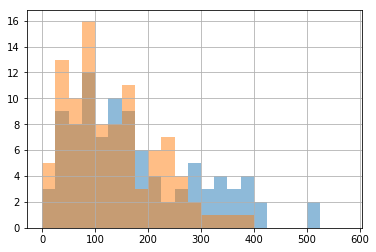

In [129]:
binsize = np.arange(0,600,25)
stock_type_age.groupby(level=0).apply(max).hist(bins=binsize, alpha=0.5)
stock_type_age.groupby(level=0).apply(min).hist(bins=binsize, alpha=0.5)
plt.show()

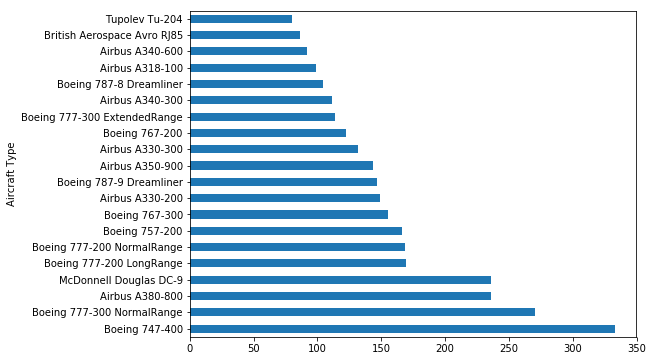

In [130]:
stock_delta_age = stock_type_age.groupby(level=0).apply(max) - stock_type_age.groupby(level=0).apply(min)
stock_delta_age.nlargest(20).plot.barh(figsize=(8,6))
plt.show()

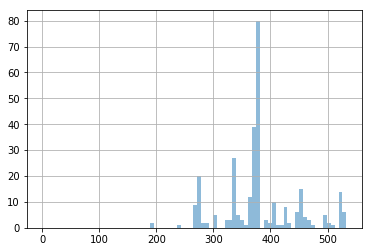

In [131]:
stock[stock['Aircraft Type'] == 'Boeing 747-400']['Seat Total'].hist(bins = 50, alpha=0.5)
stock[stock['Aircraft Type'] == 'McDonnell Douglas DC-10-30']['Seat Total'].hist(bins = 10, alpha=0.5)
plt.show()

The deviations seem to be reasonably within the range of different AC configurations. The very large (absolute) deviations are also for the very large AC.

Finally, we check whether this holds true also in relative terms. We have a look at the standard deviation of the mean seat capacity per AC type and the deviation between median and mean.

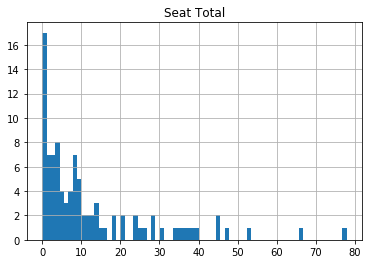

In [132]:
stock_seat_std = pd.DataFrame(stock.groupby('Aircraft Type').std()['Seat Total'])
stock_seat_std.hist(bins =70)
plt.show()

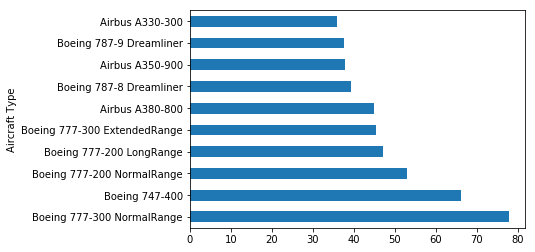

In [133]:
stock_seat_std['Seat Total'].nlargest(10).plot.barh()
plt.show()

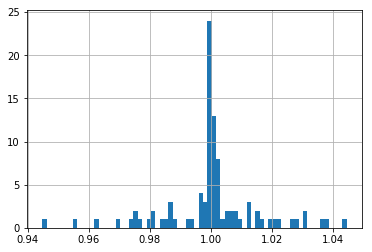

In [134]:
stock_seat_mean_median = stock.groupby('Aircraft Type').median()['Seat Total'] / stock.groupby('Aircraft Type').mean()['Seat Total']
stock_seat_mean_median.hist(bins =70)
plt.show()

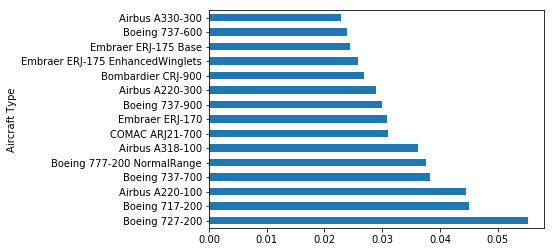

In [135]:
abs(stock_seat_mean_median-1).nlargest(15).plot.barh()
plt.show()

The observations from above are confirmed. The seat capacity information in the Planespotters data is assumed to be accurate.

**_Nota bene_**: In our fuel consumption estimation model, we consider only the average seat capacity configuration. In principle, we could also apply the whole distribution of different seat configurations. However, when matching OAG with Planespotters data (i.e. flight movements with aircraft), we do a random sampling. Hence, a detailed consideration of different seat configurations would only make sense, if we would not da a random flight-aircraft assignment, but would have information about which AC is used for which route. 

An intuitive approach to considering the seat capacity distribution would be to assign low-seat-configs to long-haul flights and high-seat-configs to short-haul flights, due to different business models (e.g. more first class seats for long-haul flights). However, a lack of data prevents this at the moment.

# Validate pre-processed AC fleet

## Total number of AC (Pax + Cargo) compared to ICAO figure

For validation, we compare the total number of AC in our fleet with the ones reported in ICAO's "Annual Report of the Council of ICAO 2018: Presentation of 2018 Air Transport Statistical Results". At the end of 2018, they report 30'379 AC (active and stored with a MTOW > 9t).

In [136]:
print("Our Pax + Cargo data set contains {} AC.".format(len(stock_Pax_Cargo)))
print("The deviation to the ones reported in ICAO's Annual report is {:.2f}%.".format((len(stock_Pax_Cargo)-30379)/30379*100))

Our Pax + Cargo data set contains 31824 AC.
The deviation to the ones reported in ICAO's Annual report is 4.76%.


However, this comparison does not take into account the "MTOW > 9t" limitation for our data set which would probably reduce the total number of AC in our data set a little bit, and hence also the deviation.

## Total number of Pax AC compared to Airbus GMF figure

For validation, we compare the total number of AC in our fleet with figures reported in literature. We take the number of 22'680 in-service AC reported in the Global Market Forecast 2019-2038 from Airbus. Since this number includes only AC with >= 100 seats and jet freight AC, we limit our entries to >= 100 seats as well.

*Nota bene:* Mail from Airbus: "This chart includes both passenger (>100 seats) and freighter (>10 ton) aircraft, in service at the beginning of 2019. Some of the stored aircraft are expected to come back to service, other have been stored for long period and will not come back to service."


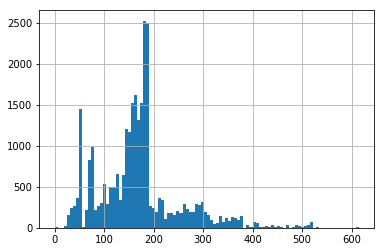

In [137]:
stock['Seat Total'].hist(bins = 100)
plt.show()

In [138]:
N_AC_100up = len(stock[stock['Seat Total'] >= 100])

In [139]:
print("The {} AC in our fleet with a seat number >= 100 compare to the reported figure of".format(N_AC_100up))
print("22'680 AC from the Global Market Forecast 2019-2038 from Airbus.")   
print("The deviation to the Airbus figure amounts to {:.2f}%.".format((N_AC_100up-22680)/22680*100))

The 23013 AC in our fleet with a seat number >= 100 compare to the reported figure of
22'680 AC from the Global Market Forecast 2019-2038 from Airbus.
The deviation to the Airbus figure amounts to 1.47%.


However,...
- (1) our AC database does not include freighter AC at this point, so we are overpredicting the number of AC in our fleet. 
- (2) our AC database excludes all aircraft that entered the fleet in August-December 2018 while the Airbus GMF number includes them.

Since our operations are based on flight movements data and not on the AC fleet, this is not a problem. The AC in our fleet here that are not used according to the flight movements data, are simply dropping out of the fleet over time by retirement. Additionally, the number of dedicated freighters is significantly lower than the number of Pax aircraft.

**Overall, we conclude that the preprocessed data set reflects reality (i.e. reported figures in literature) reasonably. In combination with flight movements data, deviations in the AC fleet data will only play a minor role when it comes to CO2 emissions.** For CO2 emission calculation, the age of the AC fleet plays a much higher role - both for AC production emissions and market penetration of new technologies due to AC retirement. However, there is no comprehensive data set reported in literature that we could compare our data set against.

---

---

# Data Analyses

In [140]:
len(stock['Aircraft Type'].unique())

97

## How old are the AC (totally and for each OEM)?

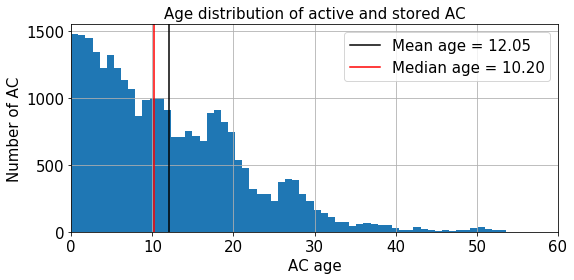

In [145]:
stock['Age (Years)'].hist(bins = 61, figsize = (8,4))
plt.axvline(x= stock['Age (Years)'].mean(), color = 'k', \
            label = str('Mean age = ' + str("{:.2f}".format(stock['Age (Years)'].mean()))))
plt.axvline(x= stock['Age (Years)'].median(), color = 'r', \
            label = str('Median age = ' + str("{:.2f}".format(stock['Age (Years)'].median()))))
plt.legend(fontsize = 15)
plt.xlabel('AC age', fontsize = 15)
plt.ylabel('Number of AC', fontsize = 15)
plt.title('Age distribution of active and stored AC', fontsize = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()
plt.xlim(0,60)
plt.savefig('..\gfx\AC_age.png', dpi=500)

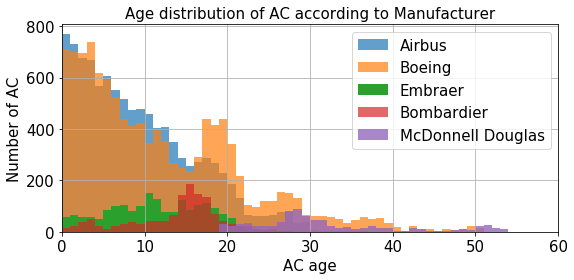

In [146]:
stock[stock['Aircraft Manufacturer'] == 'Airbus']['Age (Years)'].hist(bins = 60, range=(0,60), label = 'Airbus', figsize = (8,4), alpha=0.7)
stock[stock['Aircraft Manufacturer'] == 'Boeing']['Age (Years)'].hist(bins = 60, range=(0,60), label = 'Boeing', figsize = (8,4), alpha=0.7)
stock[stock['Aircraft Manufacturer'] == 'Embraer']['Age (Years)'].hist(bins = 60, range=(0,60), label = 'Embraer', figsize = (8,4))
stock[stock['Aircraft Manufacturer'] == 'Bombardier']['Age (Years)'].hist(bins = 60, range=(0,60), label = 'Bombardier', figsize = (8,4), alpha=0.7)
stock[stock['Aircraft Manufacturer'] == 'McDonnell Douglas']['Age (Years)'].hist(bins = 60, range=(0,60), label = 'McDonnell Douglas', figsize = (8,4), alpha=0.8)
plt.legend(fontsize = 15)
plt.xlabel('AC age', fontsize = 15)
plt.ylabel('Number of AC', fontsize = 15)
plt.title('Age distribution of AC according to Manufacturer', fontsize = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()
plt.xlim(0,60)
plt.savefig('..\gfx\AC_age_OEM.png', dpi=500)

## How many AC per manufacturer?

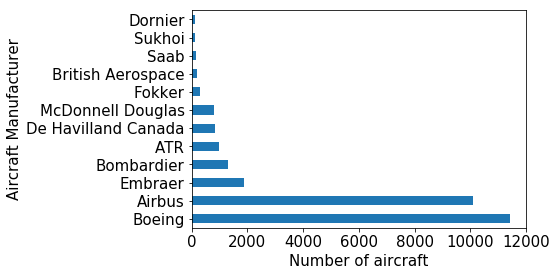

In [147]:
stock_AC_OEM = stock.groupby('Aircraft Manufacturer').size().sort_values(ascending = False) 
stock_AC_OEM[stock_AC_OEM > 50].plot.barh(fontsize = 15)
plt.xlabel('Number of aircraft', fontsize = 15)
plt.ylabel('Aircraft Manufacturer', fontsize = 15)
plt.show()

In [148]:
# Share of Airbus and Boeing on total fleet:
stock_AC_OEM[stock_AC_OEM.index.isin(['Airbus', 'Boeing'])].sum()/stock_AC_OEM.sum()

0.7575586920558939

In [149]:
# Share of Big Five on total fleet:
stock.groupby('Aircraft Manufacturer')['Age (Years)'].count().sort_values(ascending = False).iloc[0:5].sum()/stock_AC_OEM.sum()

0.9046496075463729

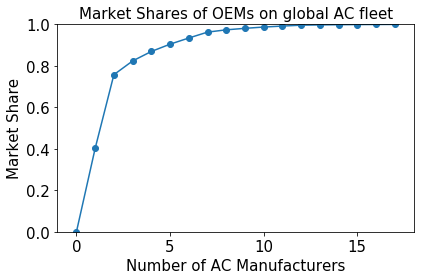

In [150]:
# Share of Big Five on total fleet:
cum_share_of_OEMs = np.array(0)
for i in np.arange(1,stock_AC_OEM.index.size):
    _cum_share = stock.groupby('Aircraft Manufacturer')['Age (Years)'].count() \
                                                                 .sort_values(ascending = False) \
                                                                 .iloc[0:i].sum()/stock_AC_OEM.sum()
    cum_share_of_OEMs = np.append(cum_share_of_OEMs,_cum_share)
plt.plot(np.arange(0,stock_AC_OEM.index.size),cum_share_of_OEMs)
plt.scatter(np.arange(0,stock_AC_OEM.index.size), cum_share_of_OEMs)

plt.ylim([0,1])
plt.legend(fontsize = 15)
plt.xlabel('Number of AC Manufacturers', fontsize = 15)
plt.ylabel("Market Share", fontsize = 15)
plt.title('Market Shares of OEMs on global AC fleet', fontsize = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()
plt.savefig('..\gfx\AC_OEM_share.png', dpi=500)

## Operator Group

In [151]:
stock_Op_Group = pd.DataFrame(stock.groupby('Operator Parent/Group').size()[stock.groupby('Operator Parent/Group')\
                                                                            .size() > 299])
stock_Op_Group = stock_Op_Group.T
stock_Op_Group['Rest of World'] = stock.groupby('Operator Parent/Group').size()[stock.groupby('Operator Parent/Group')\
                                                                      .size() < 300].sum()

stock_Op_Group = stock_Op_Group.rename(index = {0:'number of aircraft'})
stock_Op_Group = stock_Op_Group.T.sort_values(by = ['number of aircraft'], ascending = False)

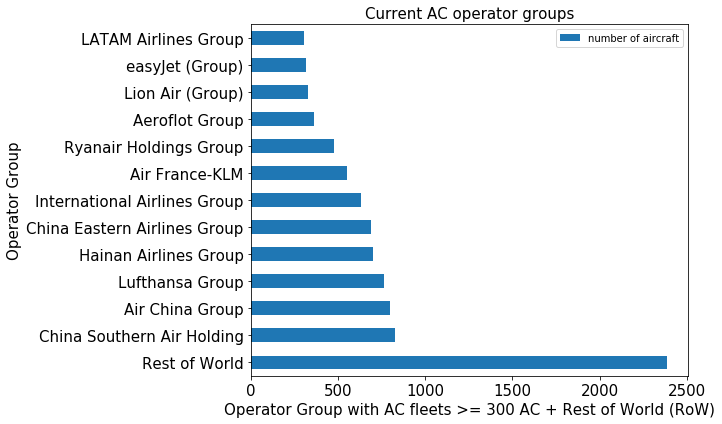

In [152]:
stock_Op_Group.plot.barh(figsize = (10,6))
plt.xlabel('Operator Group with AC fleets >= 300 AC + Rest of World (RoW)', fontsize = 15)
plt.ylabel('Operator Group', fontsize = 15)
plt.title('Current AC operator groups', fontsize = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()
plt.savefig('..\gfx\AC_operator_groups.png', dpi=500)

## How many AC per country?

### Current AC Operator Countries

In [153]:
stock_cty_cur_op = pd.DataFrame(stock.groupby('Operator Country').size()[stock.groupby('Operator Country')\
                                                                      .size() > 499])
stock_cty_cur_op = stock_cty_cur_op.T
stock_cty_cur_op['RoW'] = stock.groupby('Operator Country').size()[stock.groupby('Operator Country')\
                                                                      .size() < 500].sum()
stock_cty_cur_op = stock_cty_cur_op.rename(index = {0:'number of aircraft'})
stock_cty_cur_op = stock_cty_cur_op.T.sort_values(by = ['number of aircraft'], ascending = False)

Text(0,0.5,'Operator Country')

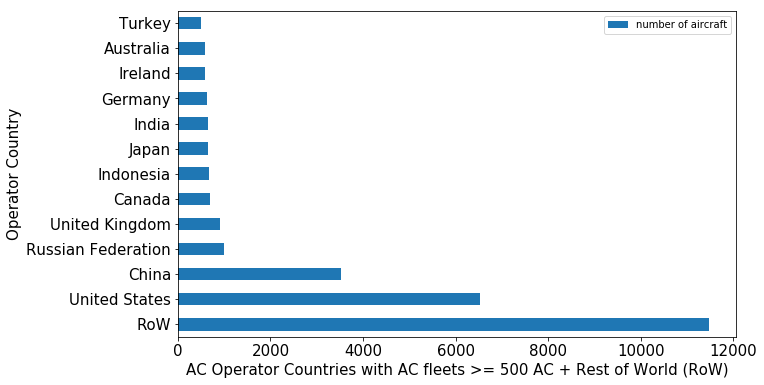

In [154]:
stock_cty_cur_op.plot.barh(fontsize = 15, figsize = (10,6))
plt.xlabel('AC Operator Countries with AC fleets >= 500 AC + Rest of World (RoW)', fontsize = 15)
plt.ylabel('Operator Country', fontsize = 15)

### First AC Operator Countries

In [155]:
stock_cty_first_op = pd.DataFrame(stock.groupby('First Operator Country').size()[stock.groupby('First Operator Country')\
                                                                      .size() > 499])
stock_cty_first_op = stock_cty_first_op.T
stock_cty_first_op['RoW'] = stock.groupby('First Operator Country').size()[stock.groupby('First Operator Country')\
                                                                      .size() < 500].sum()
stock_cty_first_op = stock_cty_first_op.rename(index = {0:'number of aircraft'})
stock_cty_first_op = stock_cty_first_op.T.sort_values(by = ['number of aircraft'], ascending = False)

Text(0,0.5,'Operator Country')

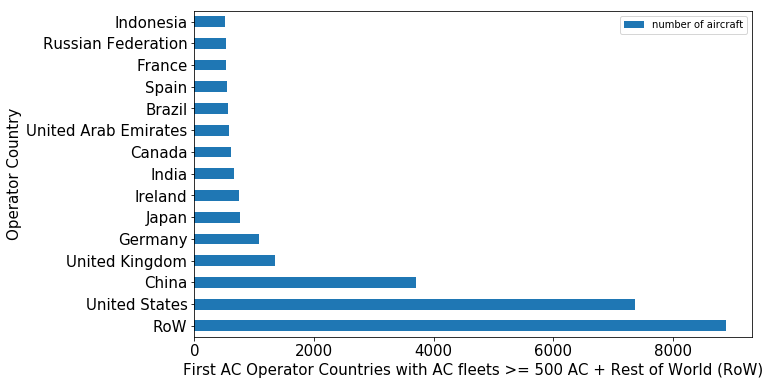

In [156]:
stock_cty_first_op.plot.barh(fontsize = 15, figsize = (10,6))
plt.xlabel('First AC Operator Countries with AC fleets >= 500 AC + Rest of World (RoW)', fontsize = 15)
plt.ylabel('Operator Country', fontsize = 15)

## Can we extract second hand market information from first operator and current operatur delivery dates?

Most common AC flows:

In [161]:
AC_flows = stock[stock['First Operator Country'] != stock['Operator Country']]\
                        .loc[:,['First Operator Country','Operator Country','First Customer Delivery Date', \
                                'Delivery Date Operator']]
AC_flows['concat_string'] = AC_flows['First Operator Country'] + '_TO_' + AC_flows['Operator Country']
AC_flows.groupby(['concat_string']).size().sort_values(ascending = False)[:10]

concat_string
United States_TO_Russian Federation    166
United States_TO_Australia             123
United Kingdom_TO_Austria              117
China_TO_United States                  73
United States_TO_Mexico                 65
United States_TO_Venezuela              61
United Kingdom_TO_United States         60
United States_TO_South Africa           58
United States_TO_Indonesia              57
Germany_TO_Austria                      53
dtype: int64

Biggest exporters and importers:

In [162]:
AC_exporters = pd.DataFrame(AC_flows.groupby('First Operator Country').size()[AC_flows.groupby('First Operator Country')\
                                                                      .size() > 199])
AC_exporters = AC_exporters.T
AC_exporters['RoW'] = AC_flows.groupby('First Operator Country').size()[AC_flows.groupby('First Operator Country')\
                                                                      .size() < 200].sum()
AC_exporters = AC_exporters.rename(index = {0:'number of aircraft'})
AC_exporters = AC_exporters.T.sort_values(by = ['number of aircraft'], ascending = False)

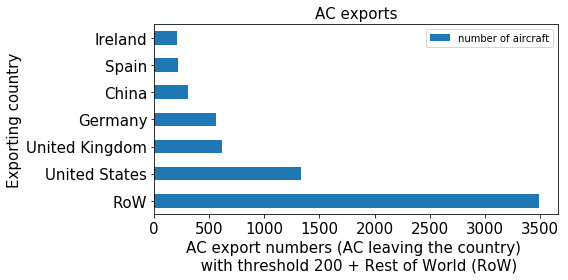

In [166]:
AC_exporters.plot.barh(figsize = (8,4))
plt.xlabel('AC export numbers (AC leaving the country) \n with threshold 200 + Rest of World (RoW)', fontsize = 15)
plt.ylabel('Exporting country', fontsize = 15)
plt.title('AC exports', fontsize = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()

In [167]:
AC_importers = pd.DataFrame(AC_flows.groupby('Operator Country').size()[AC_flows.groupby('Operator Country')\
                                                                      .size() > 199])
AC_importers = AC_importers.T
AC_importers['RoW'] = AC_flows.groupby('Operator Country').size()[AC_flows.groupby('Operator Country')\
                                                                      .size() < 200].sum()
AC_importers = AC_importers.rename(index = {0:'number of aircraft'})
AC_importers = AC_importers.T.sort_values(by = ['number of aircraft'], ascending = False)

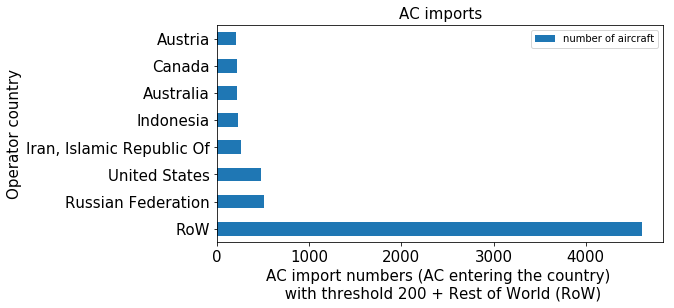

In [168]:
AC_importers.plot.barh(figsize = (8,4), fontsize = 15)
plt.xlabel('AC import numbers (AC entering the country) \n with threshold 200 + Rest of World (RoW)', fontsize = 15)
plt.ylabel('Operator country', fontsize = 15)
plt.title('AC imports', fontsize = 15)
plt.show()

We see the trends of rich countries being higher exporters vs. poorer countries being net importers. <br>
So, let's have a look at the __age distribution of exports__.

In [169]:
start_dt = AC_flows.loc[:,'First Customer Delivery Date']
end_dt = AC_flows.loc[:,'Delivery Date Operator']

AC_flows['export_age'] = pd.DataFrame(np.arange(len(AC_flows)))
_idx = AC_flows.index

for i in np.arange(len(AC_flows)):
    _exp_age = np.around(len(pd.date_range(start = start_dt.iloc[i], end = end_dt.iloc[i], freq='D')) \
                         /365, decimals =2)
    AC_flows.at[_idx[i], 'export_age'] = _exp_age

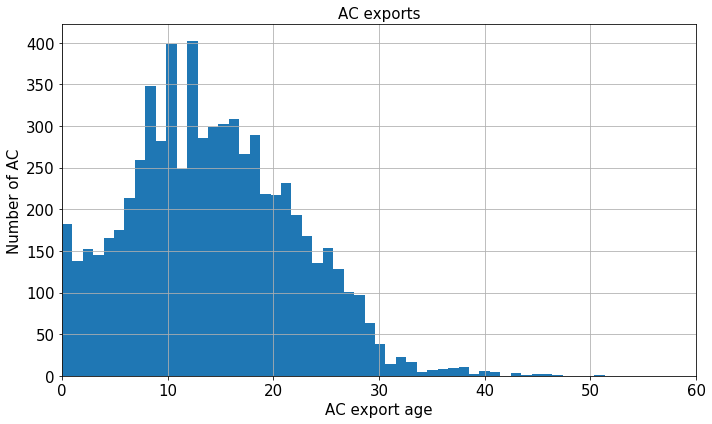

In [170]:
AC_flows['export_age'].hist(bins = 120,figsize = (10,6))
plt.xlim([0,60])
plt.xlabel('AC export age', fontsize = 15)
plt.ylabel('Number of AC', fontsize = 15)
plt.title('AC exports', fontsize = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()
plt.savefig('..\gfx\AC_export_age.png', dpi=500)

## Which country builds what AC?

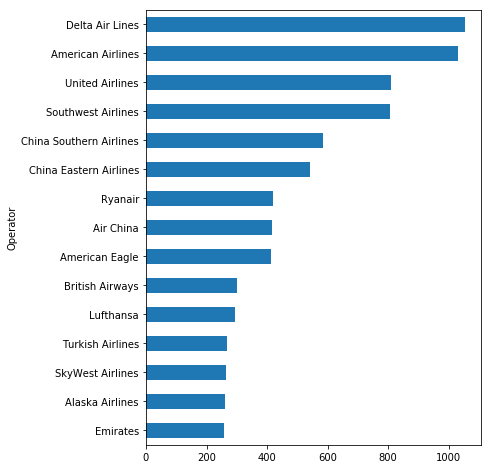

In [171]:
stock.groupby('Operator').size().nlargest(15).sort_values(ascending = True).plot.barh(figsize=(6,8))
plt.show()

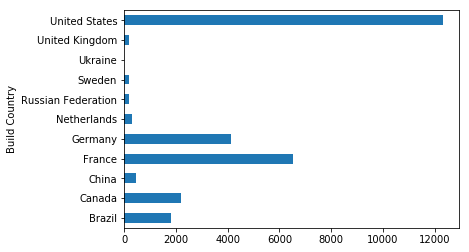

In [172]:
stock.groupby('Build Country').size().sort_index().plot.barh()
plt.show()

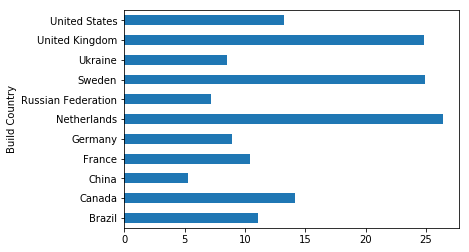

In [173]:
stock.groupby('Build Country').mean()['Age (Years)'].sort_index().plot.barh()
plt.show()

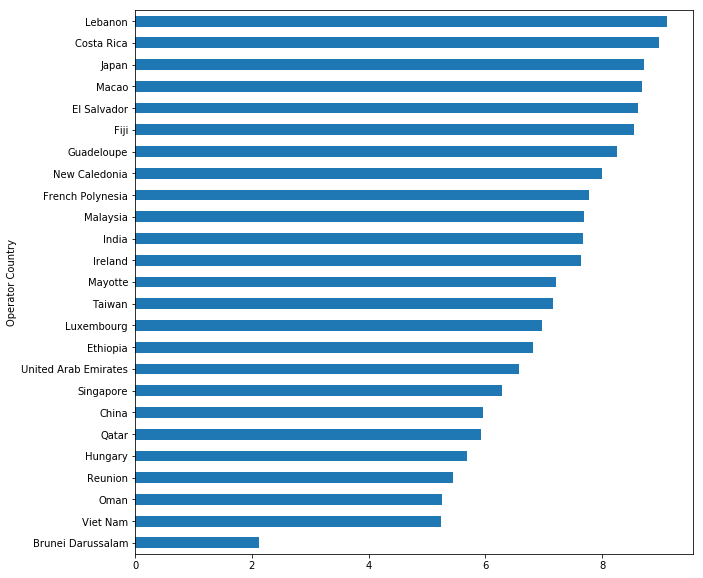

In [178]:
stock.groupby('Operator Country').mean()['Age (Years)'].sort_values(ascending = True)[:25].plot.barh(figsize=(10,10))

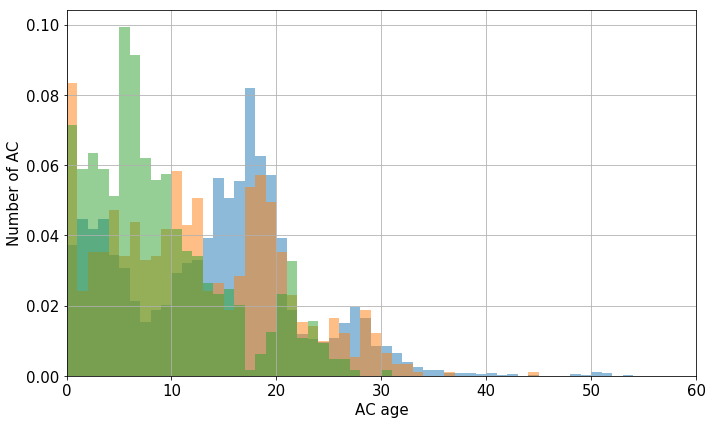

In [180]:
bins = np.arange(100)
stock[stock['Operator Country'] == 'United States']['Age (Years)'].hist(bins = bins, alpha = 0.5,figsize = (10,6), normed = True)
#stock[stock['Operator Country'] == 'China']['Age (Years)'].hist(bins = bins, alpha = 0.5, figsize = (10,6), normed = True)
#stock[stock['Operator Country'] == 'Germany']['Age (Years)'].hist(bins = bins, alpha = 0.5, figsize = (10,6), normed = True)
stock[stock['Operator Country'] == 'United Kingdom']['Age (Years)'].hist(bins = bins, alpha = 0.5, figsize = (10,6), normed = True)
stock[stock['Operator Country'] == 'Japan']['Age (Years)'].hist(bins = bins, alpha = 0.5, figsize = (10,6), normed = True)

plt.xlim([0,60])
plt.xlabel('AC age', fontsize = 15)
plt.ylabel('Number of AC', fontsize = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()

## Which engines are used?

In [181]:
stock_engine_OEMs = pd.DataFrame(stock.groupby(['Engine Manufacturer']).size() \
                              [stock.groupby(['Engine Manufacturer']).size() > 299])
stock_engine_OEMs = stock_engine_OEMs.T
stock_engine_OEMs['Others'] = stock.groupby(['Engine Manufacturer']).size() \
                              [stock.groupby(['Engine Manufacturer']).size() < 300].sum()

stock_engine_OEMs = stock_engine_OEMs.rename(index = {0:'number of aircraft'})
stock_engine_OEMs = stock_engine_OEMs.T.sort_values(by = ['number of aircraft'], ascending = False)

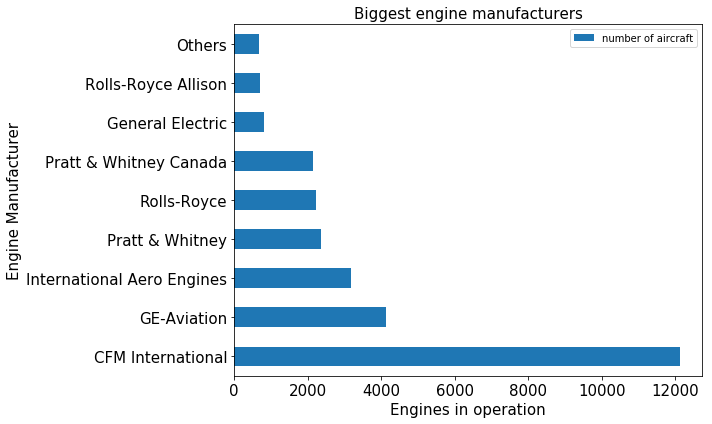

In [182]:
stock_engine_OEMs.plot.barh(figsize = (10,6))
plt.xlabel('Engines in operation', fontsize = 15)
plt.ylabel('Engine Manufacturer', fontsize = 15)
plt.title('Biggest engine manufacturers', fontsize = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()
plt.savefig('..\gfx\AC_engines.png', dpi=500)

In [183]:
stock_engine_type = pd.DataFrame(stock.groupby(['Engine Type']).size() \
                              [stock.groupby(['Engine Type']).size() > 999])
stock_engine_type = stock_engine_type.T
stock_engine_type['Others'] = stock.groupby(['Engine Type']).size() \
                              [stock.groupby(['Engine Type']).size() < 1000].sum()

stock_engine_type = stock_engine_type.rename(index = {0:'number of aircraft'})
stock_engine_type = stock_engine_type.T.sort_values(by = ['number of aircraft'], ascending = False)

Text(0,0.5,'Engine Type')

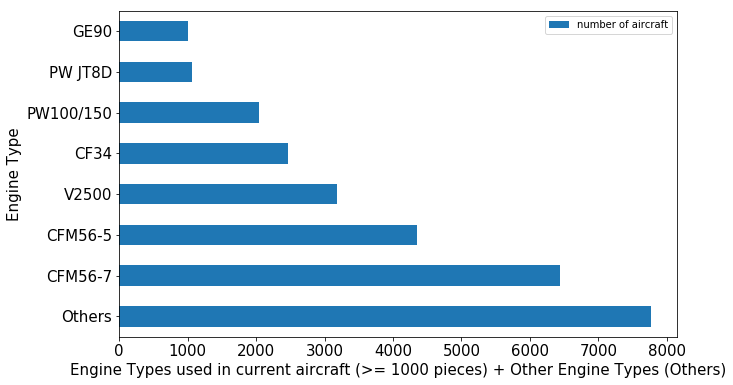

In [184]:
stock_engine_type.plot.barh(figsize = (10,6), fontsize = 15)
plt.xlabel('Engine Types used in current aircraft (>= 1000 pieces) + Other Engine Types (Others)', fontsize = 15)
plt.ylabel('Engine Type', fontsize = 15)

## How many seats do we observe for our AC fleet?

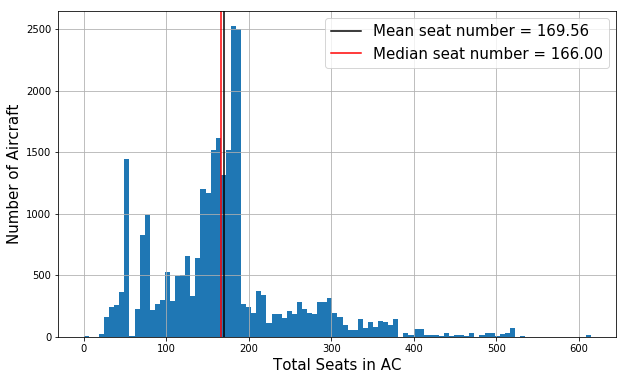

In [185]:
stock['Seat Total'].hist(bins = 100, figsize = (10,6))
plt.axvline(x= stock['Seat Total'].mean(), color = 'k', 
            label = str('Mean seat number = ' + str("{:.2f}".format(stock['Seat Total'].mean()))))
plt.axvline(x= stock['Seat Total'].median(), color = 'r', 
            label = str('Median seat number = ' + str("{:.2f}".format(stock['Seat Total'].median()))))
plt.ylabel('Number of Aircraft', fontsize = 15)
plt.xlabel('Total Seats in AC', fontsize = 15)
plt.legend(fontsize = 15)

## Which aircraft types do we observe in our AC fleet?

In [186]:
stock_AC_type = pd.DataFrame(stock.groupby(['Aircraft Type']).size() \
                              [stock.groupby(['Aircraft Type']).size() > 599])
stock_AC_type = stock_AC_type.T
stock_AC_type['Others'] = stock.groupby(['Aircraft Type']).size() \
                              [stock.groupby(['Aircraft Type']).size() < 600].sum()

stock_AC_type = stock_AC_type.rename(index = {0:'number of aircraft'})
stock_AC_type = stock_AC_type.T.sort_values(by = ['number of aircraft'], ascending = False)

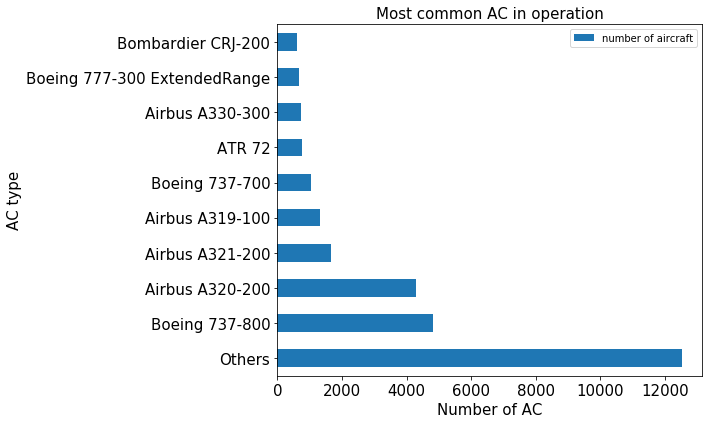

In [187]:
stock_AC_type.plot.barh(figsize = (10,6))
plt.xlabel('Number of AC', fontsize = 15)
plt.ylabel('AC type', fontsize = 15)
plt.title('Most common AC in operation', fontsize = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()
plt.savefig('..\gfx\AC_type.png', dpi=500)

# Upload

Before we upload the dataframe to our dataserver, we do some sanity checks. The following things are adjusted:
- The column 'Exit Date Operator' is deleted since it only contains about 40 non-NaN entries.
- The format of some columns is set to str, since it is currently float.

In [188]:
stock = stock.drop('Exit Date Operator', axis=1)

In [189]:
stock = stock.astype(  {'Operator Parent/Group': str}  )
stock = stock.astype(  {'Parent/Group Country': str}  )

Next, we change the column names:

In [190]:
stock = stock.rename(columns = {'Aircraft Manufacturer': 'ac_manufacturer',
                        'Aircraft Type': 'ac_type',
                        'Operator': 'operator',
                        'Operator ID': 'operator_id',
                        'Operator Category': 'operator_category',
                        'Operator Country': 'operator_country',
                        'Operator Parent/Group': 'operator_parent/group',
                        'Parent/Group ID': 'parent/group_id',
                        'Parent/Group Country': 'parent/group_country',
                        'First Operator': 'first_operator',
                        'First Operator ID': 'first_operator_id',
                        'First Operator Category': 'first_operator_category',
                        'First Operator Country': 'first_operator_country',
                        'Status': 'status',
                        'Build Country': 'build_country',
                        'Nr. of Engines': 'num_of_engines',
                        'Engine Manufacturer': 'engine_manufacturer',
                        'Engine Type': 'engine_type',
                        'Config (Pax/Combi/Cargo/Other)': 'configuration',
                        'Seat Total': 'num_of_seats',
                        'Build Date': 'build_date',
                        'First Customer Delivery Date': 'first_customer_delivery_date',
                        'Delivery Date Operator': 'operator_delivery_date',
                        'Age (Years)': 'age'
                       })
stock.head(1)

,ac_manufacturer,ac_type,operator,operator_id,operator_category,operator_country,operator_parent/group,parent/group_id,parent/group_country,first_operator,first_operator_id,first_operator_category,first_operator_country,status,build_country,num_of_engines,engine_manufacturer,engine_type,configuration,num_of_seats,build_date,first_customer_delivery_date,operator_delivery_date,age
20,Airbus,Airbus A220-100,Delta Air Lines,5673,Airline,United States,nan,NaN,nan,Delta Air Lines,5673.0,Airline,United States,Active,Canada,2,Pratt & Whitney,PW1500G,Pax,109,2018-10-01,2018-10-01,2018-10-01,0.2


Now, we create the SQL string:

In [191]:
sql_str = 'DROP TABLE IF EXISTS "Planespotters"."pax_fleet_2018_12_31"; \n\n' 
sql_str += 'CREATE TABLE "Planespotters"."pax_fleet_2018_12_31" \n (\n'
for i in stock.columns:
    if i != 'age':
        if type(stock.loc[50,i]) == str:
            max_str_len = int(stock[i].str.len().max())
            sql_str += '"' + i + '" VARCHAR(' + str(max_str_len) + '), \n'
        elif type(stock.loc[50,i]) == np.float64:
            sql_str += '"' + i + '" FLOAT(8), \n'
        elif type(stock.loc[50,i]) == np.int64:
            sql_str += '"' + i + '" INT, \n'
        else:
            sql_str += '"' + i + '" DATE, \n'
    else:
        sql_str += '"' + i + '" FLOAT(8) \n'
sql_str += ' ); \n\n COMMIT; '
print(sql_str)

DROP TABLE IF EXISTS "Planespotters"."pax_fleet_2018_12_31"; 

CREATE TABLE "Planespotters"."pax_fleet_2018_12_31" 
 (
"ac_manufacturer" VARCHAR(19), 
"ac_type" VARCHAR(36), 
"operator" VARCHAR(43), 
"operator_id" INT, 
"operator_category" VARCHAR(7), 
"operator_country" VARCHAR(38), 
"operator_parent/group" VARCHAR(35), 
"parent/group_id" FLOAT(8), 
"parent/group_country" VARCHAR(20), 
"first_operator" VARCHAR(45), 
"first_operator_id" FLOAT(8), 
"first_operator_category" VARCHAR(16), 
"first_operator_country" VARCHAR(41), 
"status" VARCHAR(6), 
"build_country" VARCHAR(18), 
"num_of_engines" INT, 
"engine_manufacturer" VARCHAR(26), 
"engine_type" VARCHAR(13), 
"configuration" VARCHAR(3), 
"num_of_seats" INT, 
"build_date" DATE, 
"first_customer_delivery_date" DATE, 
"operator_delivery_date" DATE, 
"age" FLOAT(8) 
 ); 

 COMMIT; 


And finally, we upload the data:

In [192]:
# Connect to DB
%load_ext ipython_pg.LAV
%pg_connect dbname='mobility' host='lav-fileserver.ethz.ch' user='heldm'

The ipython_pg.LAV extension is already loaded. To reload it, use:
  %reload_ext ipython_pg.LAV
password for heldm@lav-fileserver.ethz.ch:5433:········
SUCCESS: connected to lav-fileserver.ethz.ch
  PostGIS integration enabled

In [193]:
%pg_sql set role "NDA-Planespotters"

SUCCESS: query did not return any data


<cursor object at 0x0000020C08AA6828; closed: 0>

In [194]:
try:
    cur = %pg_cursor
    cur.execute(sql_str)
except Exception as e:
    print(str(e))
    %pg_rollback()

In [195]:
%pg_copy stock Planespotters.pax_fleet_2018_12_31

  waring: green-mode temporarily deactivated (interrupt won't abort the import)  green mode reactivated

In [196]:
%pg_disconnect